In [1]:
from utils.epg import *
import matplotlib.pyplot as plt
from copy import copy
cmap = copy(plt.cm.get_cmap("jet"))
from scipy.optimize import least_squares

In [2]:
degree = r"${}^{\circ}$"
GeV = "GeV"
GeV2 = "GeV"+r"${}^{2}$"
GeVc = "GeV/c"
GeVc2 = "(GeV/c)"+r"${}^{2}$"

In [3]:
import matplotlib
# initial settings
pgf_with_latex = {
		"pgf.texsystem": "pdflatex",
		"text.usetex": True,            # use LaTeX to write all text
		"font.family": "sans-serif",         
		"font.sans-serif": "Helvetica",
		"font.size": 25,				# default font size
		"axes.labelsize": 24,			# x and y label size
		"axes.titlesize": 24,           # subfigure title size, i.e. title size when one figure
		"legend.fontsize": 22,			# legend size
		"xtick.labelsize": 23,			# x axis tick label size
		"ytick.labelsize": 23,			# y axis tick label 
		"figure.titlesize": 25,         # Figure title size, useful when you have multiple plots in one canvas.
		"pgf.preamble": r"\usepackage{xcolor}",     # xcolor for colours
		"figure.autolayout": True
}
matplotlib.rcParams.update(pgf_with_latex)

def nphistmean(hist, bins):
    s=0
    for i in range(len(hist)):
        s += hist[i] * ((bins[i] + bins[i+1]) / 2) 
    mean = s / np.sum(hist)
    return mean

In [4]:
def reDefineDVCS(df_epg):

    df_epg.loc[:, 'newPe'] = df_epg.t2/2/M + M
    df_epg.loc[:, 'newPp'] = np.sqrt(df_epg.newPe**2 - M**2)
    df_epg.loc[:, 'newGp'] = df_epg.nu - df_epg.t2/M/2
    
    df_epg.loc[:, 'dPp'] = df_epg.loc[:, 'newPp'] -  df_epg.loc[:, 'Pp']
    df_epg.loc[:, 'dGp'] = df_epg.loc[:, 'newGp'] -  df_epg.loc[:, 'Gp']

    return df_epg

## correcting FT phton in exp

In [391]:
parent_MC = "/Volumes/Extreme SSD/nov2021/convPkl/dvcs/"
parent_MC_bkg1g = "/Volumes/Extreme SSD/nov2021/convPkl/bkg_1g/"
parent_MC_bkg2g = "/Volumes/Extreme SSD/nov2021/convPkl/bkg_2g/"
parent_exp = "/Volumes/Extreme SSD/nov2021/convPkl/exp/"

df_3987_corr = pd.read_pickle(parent_MC + "3987.pkl")
df_4076_1g_corr = pd.read_pickle(parent_MC_bkg1g + "4076.pkl")
df_4076_2g_corr = pd.read_pickle(parent_MC_bkg2g + "4076.pkl")
exp_1g_corr = pd.read_pickle(parent_exp + "dvcs.pkl")
exp_2g_corr = pd.read_pickle(parent_exp + "pi0.pkl")

In [392]:
epgExpInb = copy(exp_1g_corr)
pi0ExpInb = copy(exp_2g_corr)
dvcsSimInb = copy(df_3987_corr)
bkgSimInb = copy(df_4076_1g_corr)
pi0SimInb = copy(df_4076_2g_corr)

In [393]:
epgExpInbCDFT = epgExpInb.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector>7)]
pi0ExpInbCDFT = pi0ExpInb.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>3)&(exp_2g_corr.Pp>0.25)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector>7)&(exp_2g_corr.Ptheta<60))& (exp_2g_corr.Gsector>7)& (exp_2g_corr.Gsector2>7)]
dvcsSimInbCDFT = dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>3)&(dvcsSimInb.Pp>0.25)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector>7)&(dvcsSimInb.Ptheta<60))& (dvcsSimInb.Gsector>7)]
bkgSimInbCDFT = bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>3)&(bkgSimInb.Pp>0.25)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector>7)&(bkgSimInb.Ptheta<60))& (bkgSimInb.Gsector>7)]
pi0SimInbCDFT = pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>3)&(pi0SimInb.Pp>0.25)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector>7)&(pi0SimInb.Ptheta<60))& (pi0SimInb.Gsector>7)]

In [21]:
def correctDVCS(df_epg, correction=0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
#     df_epg.loc[:, 'Pp'] = mag(pro)
#     df_epg.loc[:, 'Pe'] = getEnergy(pro, 0)
#     df_epg.loc[:, 'Ptheta'] = getTheta(pro)
#     df_epg.loc[:, 'Pphi'] = getPhi(pro)

    df_epg.loc[df_epg.Gsector>7, 'Gp'] = df_epg.loc[df_epg.Gsector>7, 'Gp'] + correction
    df_epg.loc[df_epg.Gsector>7, 'Ge'] = df_epg.loc[df_epg.Gsector>7, 'Ge'] + correction
#     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
#     df_epg.loc[:, 'Gphi'] = getPhi(gam)
    df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]

    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


In [32]:
def smearingDVCS(df_epg, sigma = 0, sigma2 = 0, sigma3 = 0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
#     df_epg.loc[:, 'Pp'] = mag(pro)
#     df_epg.loc[:, 'Pe'] = getEnergy(pro, 0)
#     df_epg.loc[:, 'Ptheta'] = getTheta(pro)
#     df_epg.loc[:, 'Pphi'] = getPhi(pro)

    df_epg.loc[df_epg.Gsector>7, 'Gp'] = np.random.normal(1, sigma, len(df_epg.loc[df_epg.Gsector>7]))*df_epg.loc[df_epg.Gsector>7, 'Gp']
    df_epg.loc[df_epg.Gsector>7, 'Gtheta'] = np.random.normal(0, sigma2, len(df_epg.loc[df_epg.Gsector>7]))+df_epg.loc[df_epg.Gsector>7, 'Gtheta']
    df_epg.loc[df_epg.Gsector>7, 'Gphi'] = np.random.normal(0, sigma3, len(df_epg.loc[df_epg.Gsector>7]))+df_epg.loc[df_epg.Gsector>7, 'Gphi']
    df_epg.loc[df_epg.Gsector>7, 'Ge'] = df_epg.loc[df_epg.Gsector>7, 'Gp']
#     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
#     df_epg.loc[:, 'Gphi'] = getPhi(gam)
    df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]
    
    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


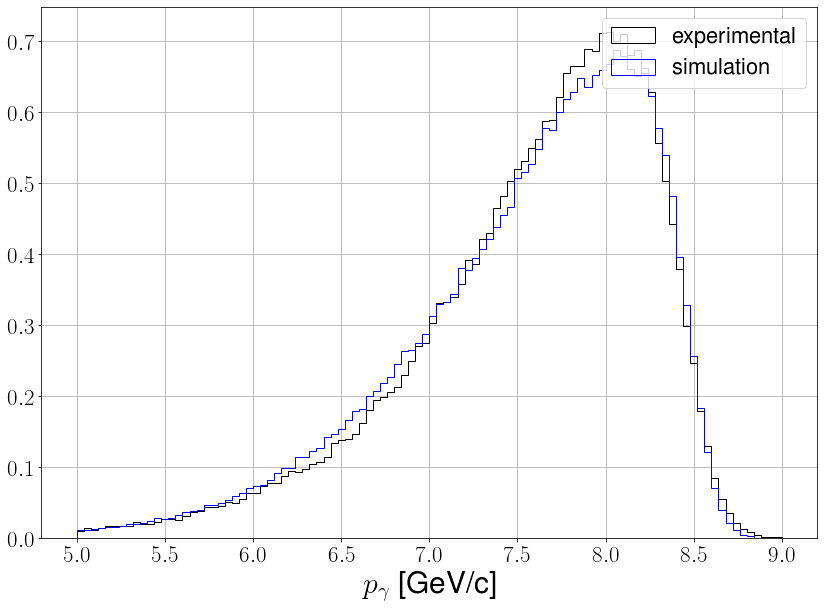

In [399]:
plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams["axes.titlesize"] = 35
plt.rcParams["axes.labelsize"] = 30
correctDVCS(epgExpInbCDFT, 0.25).Gp.hist(bins = np.linspace(5, 9, 101), density = True, histtype = 'step', color = 'k', label = 'experimental')
smearingDVCS(dvcsSimInbCDFT, 0.01, 0, 0).Gp.hist(bins = np.linspace(5, 9, 101), density = True, histtype = 'step', color = 'b', label = 'simulation')
plt.legend(loc='upper right')
plt.xlabel(r"$p_{\gamma}$" + " ["+GeVc+"]")
# plt.axvline(M**2, linestyle='--', color = 'k')
plt.show()


Gp
Gtheta
Gphi
coneAngle
reconGam
t2
ME_epg
MM2_epg
MM2_eg
coplanarity


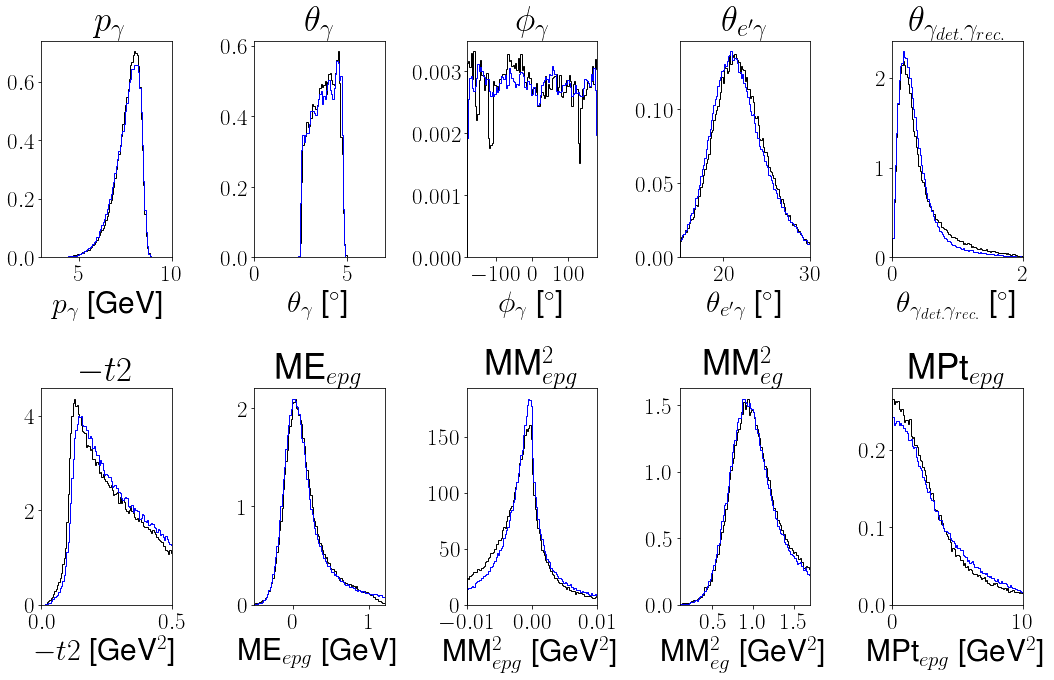

<Figure size 864x648 with 0 Axes>

In [419]:
df = smearingDVCS(dvcsSimInbCDFT, 0.014, 0, 4)

#photon related
varstoplot = ["Gp", "Gtheta", "Gphi", "coneAngle",  "reconGam", "t2", "ME_epg", "MM2_epg", "MM2_eg", "coplanarity"]
title = [r"$p_{\gamma}$", r"$\theta_{\gamma}$", r"$\phi_{\gamma}$", r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$-t2$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, GeV2, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [3, 0, -180, 15, 0, 0, -0.5, -0.01, 0.1, 0]
binends = [10, 7, 180, 30, 2, .5, 1.2, 0.01, 1.7, 10]
fig, axs = plt.subplots(2, 5, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,5):
        ind = 5*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
#         simDist_dvpi0, bins = np.histogram(smearingDVCS2(bkgSimInbCDFT, 0.05, 0, 0)[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(df[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0 + (len_epgExpInbCDFT/len_dvcsSimInbCDFT-len_bkgSimInbCDFT/len_pi0SimInbCDFT*len_pi0ExpInbCDFT/len_dvcsSimInbCDFT)*simDist_dvcs
        simDist = simDist_dvcs# + contCDFT*simDist_dvpi0
#         expDist, bins = np.histogram(correctDVCS(epgExpInbCDFT, 0.25)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCDFT-cont_inb_CDFT/len_dvcsSimInbCDFT)*len_epgExpInbCDFT*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(correctDVCS(epgExpInbCDFT, 0.25)[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind])#, nphistmean(expDist - len(pi0ExpInbCDFT)/len(pi0SimInbCDFT)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCDFT.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

## Validation of FT correction and smearing/ CD proton correction and smearing

In [691]:
ver = "FT"

parent_MC = "/Volumes/Extreme SSD/nov2021/convPkl_"+ver+"/dvcs/"
parent_MC_bkg1g = "/Volumes/Extreme SSD/nov2021/convPkl_"+ver+"/bkg_1g/"
parent_MC_bkg2g = "/Volumes/Extreme SSD/nov2021/convPkl_"+ver+"/bkg_2g/"
parent_exp = "/Volumes/Extreme SSD/nov2021/convPkl_"+"CDcorr"+"/exp/"

df_3987_corr = pd.read_pickle(parent_MC + "3987.pkl")
df_4076_1g_corr = pd.read_pickle(parent_MC_bkg1g + "4076.pkl")
df_4076_2g_corr = pd.read_pickle(parent_MC_bkg2g + "4076.pkl")
exp_1g_corr = pd.read_pickle(parent_exp + "dvcs_050.pkl")
exp_2g_corr = pd.read_pickle(parent_exp + "pi0_050.pkl")

In [692]:
epgExpInb = copy(exp_1g_corr)
pi0ExpInb = copy(exp_2g_corr)
dvcsSimInb = copy(df_3987_corr)
bkgSimInb = copy(df_4076_1g_corr)
pi0SimInb = copy(df_4076_2g_corr)

In [693]:
epgExpInbCDFT = epgExpInb.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector>7)]
pi0ExpInbCDFT = pi0ExpInb.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>3)&(exp_2g_corr.Pp>0.25)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector>7)&(exp_2g_corr.Ptheta<60))& (exp_2g_corr.Gsector>7)& (exp_2g_corr.Gsector2>7)]
dvcsSimInbCDFT = dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>3)&(dvcsSimInb.Pp>0.25)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector>7)&(dvcsSimInb.Ptheta<60))& (dvcsSimInb.Gsector>7)]
bkgSimInbCDFT = bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>3)&(bkgSimInb.Pp>0.25)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector>7)&(bkgSimInb.Ptheta<60))& (bkgSimInb.Gsector>7)]
pi0SimInbCDFT = pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>3)&(pi0SimInb.Pp>0.25)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector>7)&(pi0SimInb.Ptheta<60))& (pi0SimInb.Gsector>7)]

In [567]:
contCDFT = len(pi0ExpInbCDFT)*len(bkgSimInbCDFT)/len(pi0SimInbCDFT)/len(epgExpInbCDFT)

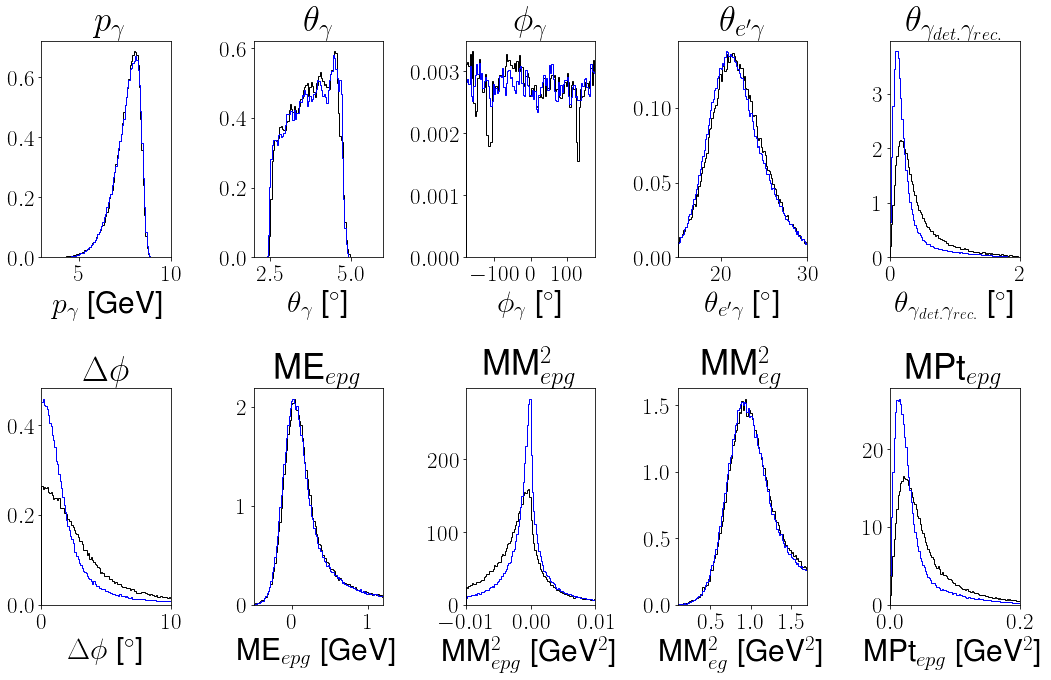

<Figure size 864x648 with 0 Axes>

In [479]:
#photon related
varstoplot = ["Gp", "Gtheta", "Gphi", "coneAngle",  "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MPt"]
title = [r"$p_{\gamma}$", r"$\theta_{\gamma}$", r"$\phi_{\gamma}$", r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [3, 2, -180, 15, 0, 0, -0.5, -0.01, 0.1, 0]
binends = [10, 6, 180, 30, 2, 10, 1.2, 0.01, 1.7, 0.2]
fig, axs = plt.subplots(2, 5, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,5):
        ind = 5*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
#         simDist_dvpi0, bins = np.histogram(bkgSimInbCDFT[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(smearingDVCS(dvcsSimInbCDFT, 0, 0, 0)[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0 + (len_epgExpInbCDFT/len_dvcsSimInbCDFT-len_bkgSimInbCDFT/len_pi0SimInbCDFT*len_pi0ExpInbCDFT/len_dvcsSimInbCDFT)*simDist_dvcs
#         simDist = (1-contCDFT)*simDist_dvcs + contCDFT*simDist_dvpi0
        simDist = simDist_dvcs
#         expDist, bins = np.histogram(correctDVCS(epgExpInbCDFT, 0.25)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCDFT-cont_inb_CDFT/len_dvcsSimInbCDFT)*len_epgExpInbCDFT*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0, where='mid',color='k', linewidth=1)
#         print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbCDFT)/len(pi0SimInbCDFT)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCDFT.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

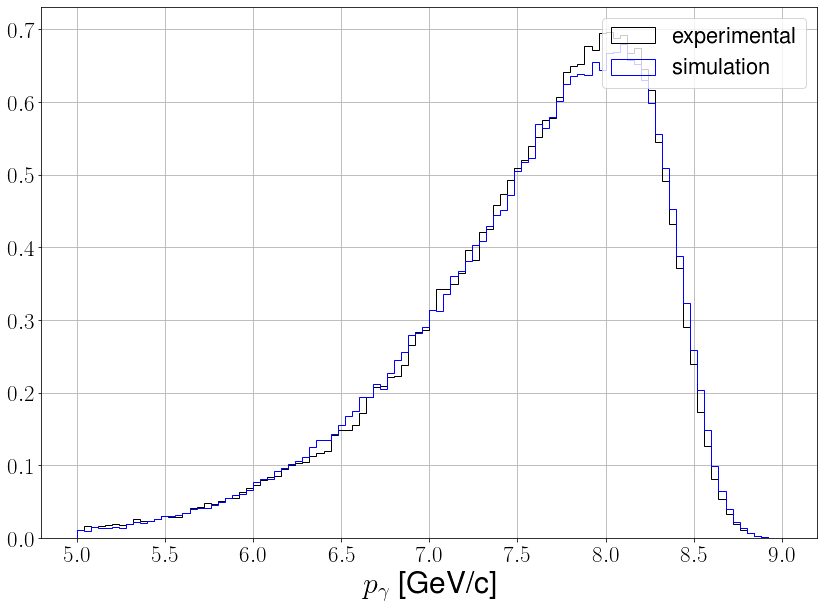

In [162]:
plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams["axes.titlesize"] = 35
plt.rcParams["axes.labelsize"] = 30
epgExpInbCDFT.Gp.hist(bins = np.linspace(5, 9, 101), density = True, histtype = 'step', color = 'k', label = 'experimental')
dvcsSimInbCDFT.Gp.hist(bins = np.linspace(5, 9, 101), density = True, histtype = 'step', color = 'b', label = 'simulation')
plt.legend(loc='upper right')
plt.xlabel(r"$p_{\gamma}$" + " ["+GeVc+"]")
# plt.axvline(M**2, linestyle='--', color = 'k')
plt.show()


In [163]:
def correctDVCS2(df_epg, correction=0, correction2 =0, correction3=0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    df_epg.loc[df_epg.Psector>7, 'Pp'] = df_epg.loc[df_epg.Psector>7, 'Pp'] + correction
    df_epg.loc[df_epg.Psector>7, 'Pe'] = np.sqrt(df_epg.loc[df_epg.Psector>7, 'Pp']**2+M**2)
    df_epg.loc[df_epg.Psector>7, 'Ptheta'] = df_epg.loc[df_epg.Psector>7, 'Ptheta'] + correction2
    df_epg.loc[df_epg.Psector>7, 'Pphi'] = df_epg.loc[df_epg.Psector>7, 'Pphi'] + correction3
    df_epg.loc[:, "Ppx"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.cos(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppy"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.sin(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppz"] = df_epg.loc[:, "Pp"]*np.cos(np.radians(df_epg.loc[:, "Ptheta"]))
    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
    
#     df_epg.loc[df_epg.Gsector>7, 'Gp'] = df_epg.loc[df_epg.Gsector>7, 'Gp'] + 0.25
#     df_epg.loc[df_epg.Gsector>7, 'Ge'] = df_epg.loc[df_epg.Gsector>7, 'Ge'] + 0.25
# #     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
# #     df_epg.loc[:, 'Gphi'] = getPhi(gam)
#     df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]

    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


In [495]:
def smearingDVCS2(df_epg, sigma = 0, sigma2 = 0, sigma3 = 0):
    #set up dvcs variables
    df_epg = copy(df_epg)

#     df_epg.loc[:, 'Ep'] = np.random.normal(1, sigma, len(df_epg.loc[:]))*df_epg.loc[:, 'Ep']
#     df_epg.loc[:, 'Etheta'] = np.random.normal(0, sigma2, len(df_epg.loc[:]))+df_epg.loc[:, 'Etheta']
#     df_epg.loc[:, 'Ephi'] = np.random.normal(0, sigma3, len(df_epg.loc[:]))+df_epg.loc[:, 'Ephi']
#     df_epg.loc[:, 'Ee'] = np.sqrt(df_epg.loc[:, 'Ep']**2+me**2)
#     df_epg.loc[:, "Epx"] = df_epg.loc[:, "Ep"]*np.sin(np.radians(df_epg.loc[:, "Etheta"]))*np.cos(np.radians(df_epg.loc[:, "Ephi"]))
#     df_epg.loc[:, "Epy"] = df_epg.loc[:, "Ep"]*np.sin(np.radians(df_epg.loc[:, "Etheta"]))*np.sin(np.radians(df_epg.loc[:, "Ephi"]))
#     df_epg.loc[:, "Epz"] = df_epg.loc[:, "Ep"]*np.cos(np.radians(df_epg.loc[:, "Etheta"]))
    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]

    df_epg.loc[df_epg.Psector>7, 'Pp'] = np.random.normal(1, sigma, len(df_epg.loc[df_epg.Psector>7]))*df_epg.loc[df_epg.Psector>7, 'Pp']
    df_epg.loc[df_epg.Psector>7, 'Ptheta'] = np.random.normal(0, sigma2, len(df_epg.loc[df_epg.Psector>7]))+df_epg.loc[df_epg.Psector>7, 'Ptheta']
    df_epg.loc[df_epg.Psector>7, 'Pphi'] = np.random.normal(0, sigma3, len(df_epg.loc[df_epg.Psector>7]))+df_epg.loc[df_epg.Psector>7, 'Pphi']
    df_epg.loc[df_epg.Psector>7, 'Pe'] = np.sqrt(df_epg.loc[df_epg.Psector>7, 'Pp']**2+M**2)
    df_epg.loc[:, "Ppx"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.cos(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppy"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.sin(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppz"] = df_epg.loc[:, "Pp"]*np.cos(np.radians(df_epg.loc[:, "Ptheta"]))
    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]

#     df_epg.loc[:, 'Gp'] = np.random.normal(1, sigma, len(df_epg))*df_epg.loc[:, 'Gp']
#     df_epg.loc[:, 'Ge'] = df_epg.loc[:, 'Gp']
# #     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
# #     df_epg.loc[:, 'Gphi'] = getPhi(gam)
#     df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]
    
    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


In [237]:
def makeDVCS(df_epg):
    #make dvcs pairs
    df_dvcs = df_epg
    df_dvcs = df_dvcs[df_dvcs["MM2_eg"] > 0]  # mmeg

    cut_xBupper = df_dvcs["xB"] < 1  # xB
    cut_xBlower = df_dvcs["xB"] > 0  # xB
    cut_Q2 = df_dvcs["Q2"] > 1  # Q2
    cut_W = df_dvcs["W"] > 2  # W
    cut_Ee = df_dvcs["Ee"] > 1  # Ee
    cut_Ge = df_dvcs["Ge"] > 1  # Ge
    cut_Pp = mag([df_dvcs["Ppx"], df_dvcs["Ppy"], df_dvcs["Ppz"]]) > 0.12  # Pp
    cut_Vz = np.abs(df_dvcs["Evz"] - df_dvcs["Pvz"]) < 2.5 + 2.5 / mag([df_dvcs["Ppx"], df_dvcs["Ppy"], df_dvcs["Ppz"]])

    # proton reconstruction quality
    # cut_FD_proton = (df_dvcs.loc[:, "Psector"]<7) & (df_dvcs.loc[:, "Ptheta"]<35)
    # cut_CD_proton = (df_dvcs.loc[:, "Psector"]>7) & (df_dvcs.loc[:, "Ptheta"]>45) & (df_dvcs.loc[:, "Ptheta"]<65)
    # cut_FD_proton = (df_dvcs.loc[:, "Psector"]<7) #& (df_dvcs.loc[:, "Ptheta"]<37)
    # cut_CD_proton = (df_dvcs.loc[:, "Psector"]>7) #& (df_dvcs.loc[:, "Ptheta"]<66) #& (df_dvcs.loc[:, "Ptheta"]>40) 
    # cut_proton = (cut_FD_proton)|(cut_CD_proton)
    cut_proton = 1 #(cut_FD_proton)|(cut_CD_proton)

    #   Exclusivity cuts
    cut_mmepg = np.abs(df_dvcs["MM2_epg"]) < 0.1  # mmepg
    cut_mmep = np.abs(df_dvcs["MM2_ep"]) < 0.6  # mmep
    cut_mmegupper = df_dvcs["MM2_eg"] < 3  # mmeg
    cut_mmeglower = df_dvcs["MM2_eg"] > 0  # mmeg
    cut_meepgupper = df_dvcs["ME_epg"] < 1.5  # meepg
    cut_meepglower = df_dvcs["ME_epg"] > -0.5  # meepg
    cut_mpt = df_dvcs["MPt"] < 0.25  # mpt
    cut_cone = df_dvcs["coneAngle"] > 5  # coneangle
    cut_recon = df_dvcs["reconGam"] < 2.5  # recon gam angle
    cut_coplanarity = df_dvcs["coplanarity"] < 25  # coplanarity angle
    if "Esector" in df_dvcs:
        cut_sector = df_dvcs["Esector"]!=df_dvcs["Gsector"]
    else:
        cut_sector = 1

    df_dvcs = df_dvcs[cut_xBupper & cut_xBlower & cut_Q2 & cut_W & cut_proton & cut_Ee & cut_Ge & cut_Pp & cut_Vz & cut_mmepg & cut_mmep &
                     cut_mmegupper & cut_mmeglower & cut_meepgupper & cut_meepglower & cut_mpt & cut_cone & cut_recon & cut_sector]

    # #dealing with duplicates
    # df_dvcs = df_dvcs.sort_values(by=['Ge', 'Psector', 'Gsector'], ascending = [False, True, True])
    # df_dvcs = df_dvcs.loc[~df_dvcs.event.duplicated(), :]
    # df_dvcs = df_dvcs.sort_values(by='event')
    return df_dvcs               


t1
Ptheta
Pphi
reconGam
coplanarity
ME_epg
MM2_epg
MM2_ep
MPt


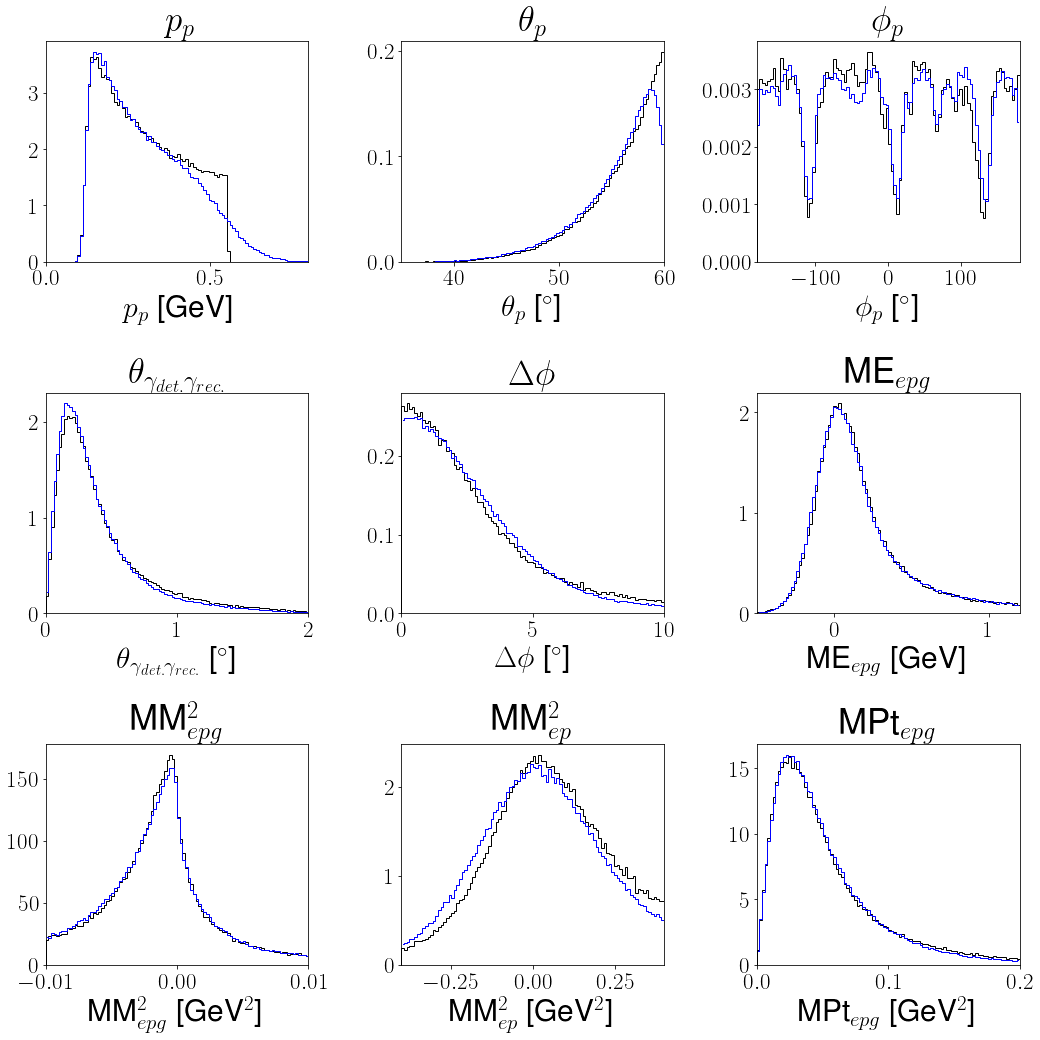

<Figure size 864x648 with 0 Axes>

In [694]:
#proton related
# df = makeDVCS(smearingDVCS2(dvcsSimInbCDFT, 0.04, 0, 0))
df = smearingDVCS2(dvcsSimInbCDFT, np.abs(0.18*(1/(1+np.exp(-(dvcsSimInbCDFT.Pp-0.3)/0.1))-0.5)), 0.8, 2.2)

varstoplot = ["t1", "Ptheta", "Pphi",  "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_ep", "MPt"]
title = [r"$p_{p}$", r"$\theta_{p}$", r"$\phi_{p}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [0, 35, -180, 0, 0, -0.5, -0.01, -0.4, 0]
binends = [0.8, 60, 180, 2, 10, 1.2, 0.01, 0.4, 0.2]
fig, axs = plt.subplots(3, 3, figsize = (15,15))
for yind in range(0, 3):
    for xind in range(0,3):
        ind = 3*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
#         simDist_dvpi0, bins = np.histogram(smearingDVCS2(bkgSimInbCDFT, 0.5*bkgSimInbCDFT.Pp**2, 0.7, 2.2)[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(df[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0 + (len_epgExpInbCDFT/len_dvcsSimInbCDFT-len_bkgSimInbCDFT/len_pi0SimInbCDFT*len_pi0ExpInbCDFT/len_dvcsSimInbCDFT)*simDist_dvcs
#         simDist = (1-contCDFT)*simDist_dvcs + contCDFT*simDist_dvpi0
        simDist = simDist_dvcs
#         expDist, bins = np.histogram(correctDVCS(epgExpInbCDFT, 0.25)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCDFT-cont_inb_CDFT/len_dvcsSimInbCDFT)*len_epgExpInbCDFT*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind])#, nphistmean(expDist - len(pi0ExpInbCDFT)/len(pi0SimInbCDFT)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCDFT.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

In [502]:
epgExpInbCD = copy(exp_1g_corr.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector<7)])
pi0ExpInbCD = copy(exp_2g_corr.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>3)&(exp_2g_corr.Pp>0.25)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector>7)&(exp_2g_corr.Ptheta<60))& (exp_2g_corr.Gsector<7)& (exp_2g_corr.Gsector2<7)])
dvcsSimInbCD = copy(dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>3)&(dvcsSimInb.Pp>0.25)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector>7)&(dvcsSimInb.Ptheta<60))& (dvcsSimInb.Gsector<7)])
bkgSimInbCD = copy(bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>3)&(bkgSimInb.Pp>0.25)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector>7)&(bkgSimInb.Ptheta<60))& (bkgSimInb.Gsector<7)])
pi0SimInbCD = copy(pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>3)&(pi0SimInb.Pp>0.25)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector>7)&(pi0SimInb.Ptheta<60))& (pi0SimInb.Gsector<7)])

In [503]:
contCD = len(pi0ExpInbCD)*len(bkgSimInbCD)/len(pi0SimInbCD)/len(epgExpInbCD)

In [772]:
def correctDVCS3(df_epg, correction=0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
#     df_epg.loc[:, 'Pp'] = mag(pro)
#     df_epg.loc[:, 'Pe'] = getEnergy(pro, 0)
#     df_epg.loc[:, 'Ptheta'] = getTheta(pro)
#     df_epg.loc[:, 'Pphi'] = getPhi(pro)

    df_epg.loc[df_epg.Gsector<7, 'Gp'] = df_epg.loc[df_epg.Gsector<7, 'Gp'] + correction
    df_epg.loc[df_epg.Gsector<7, 'Ge'] = df_epg.loc[df_epg.Gsector<7, 'Gp']
#     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
#     df_epg.loc[:, 'Gphi'] = getPhi(gam)
    df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]

    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg

t2
Ptheta
Pphi
reconGam
coplanarity
ME_epg
MM2_epg
MM2_ep
MPt


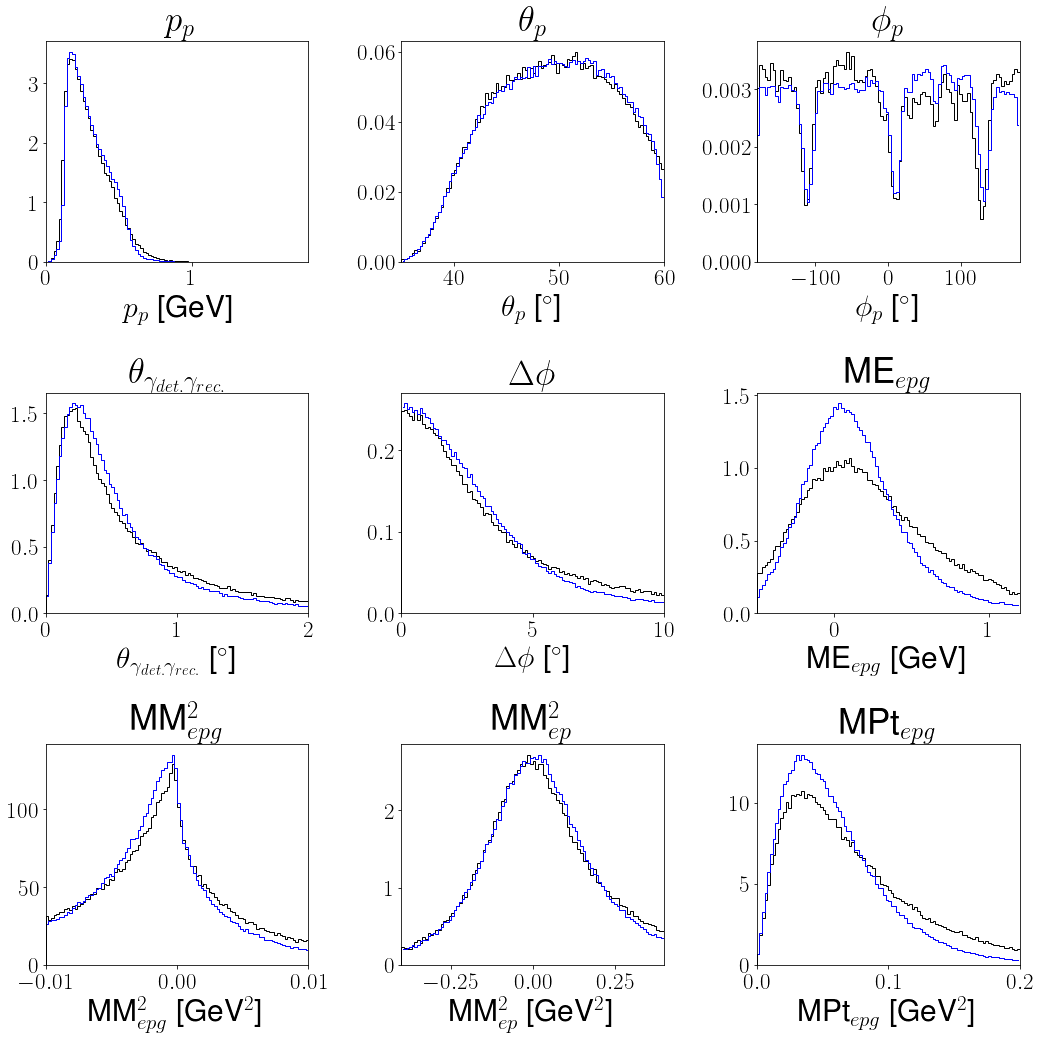

<Figure size 864x648 with 0 Axes>

In [507]:
#proton related
df = makeDVCS(smearingDVCS2(dvcsSimInbCD, 0.08, 0.5, 2.2))
df2 = makeDVCS(smearingDVCS2(bkgSimInbCD, 0.08, 0.5, 2.2))

varstoplot = ["t2", "Ptheta", "Pphi",  "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_ep", "MPt"]
title = [r"$p_{p}$", r"$\theta_{p}$", r"$\phi_{p}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [0, 35, -180, 0, 0, -0.5, -0.01, -0.4, 0]
binends = [1.8, 60, 180, 2, 10, 1.2, 0.01, 0.4, 0.2]
fig, axs = plt.subplots(3, 3, figsize = (15,15))
for yind in range(0, 3):
    for xind in range(0,3):
        ind = 3*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(df2[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(df[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0 + (len_epgExpInbCDFT/len_dvcsSimInbCDFT-len_bkgSimInbCDFT/len_pi0SimInbCDFT*len_pi0ExpInbCDFT/len_dvcsSimInbCDFT)*simDist_dvcs
        simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
        simDist = simDist_dvcs
#         expDist, bins = np.histogram(correctDVCS(epgExpInbCDFT, 0.25)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCDFT-cont_inb_CDFT/len_dvcsSimInbCDFT)*len_epgExpInbCDFT*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(correctDVCS3(epgExpInbCD, 0.0045*epgExpInbCD.Gp*epgExpInbCD.Gp)[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind])#, nphistmean(expDist - len(pi0ExpInbCDFT)/len(pi0SimInbCDFT)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCDFT.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

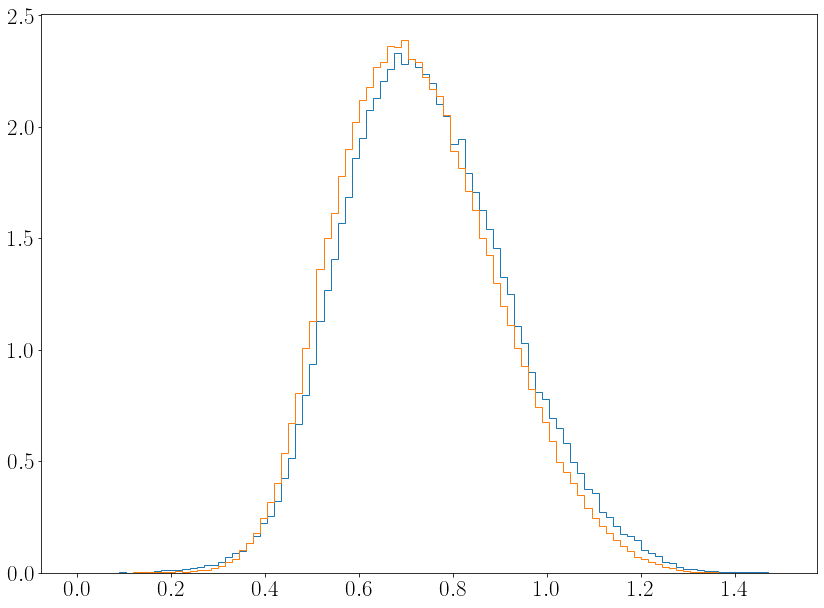

In [336]:
plt.hist((correctDVCS2(epgExpInbCDFT, 0.01, -0.26, 0).Ppx + correctDVCS2(epgExpInbCDFT, 0.01, -0.36, 0).Gpx)**2+(correctDVCS2(epgExpInbCDFT, 0.01, -0.36, 0).Ppy + correctDVCS2(epgExpInbCDFT, 0.01, -0.36, 0).Gpy)**2, bins = np.linspace(0, 1.5, 101), density = True, histtype = 'step')
plt.hist((dvcsSimInbCDFT.Ppx + dvcsSimInbCDFT.Gpx)**2+(dvcsSimInbCDFT.Ppy + dvcsSimInbCDFT.Gpy)**2, bins = np.linspace(0, 1.5, 101), density = True, histtype = 'step')
plt.show()

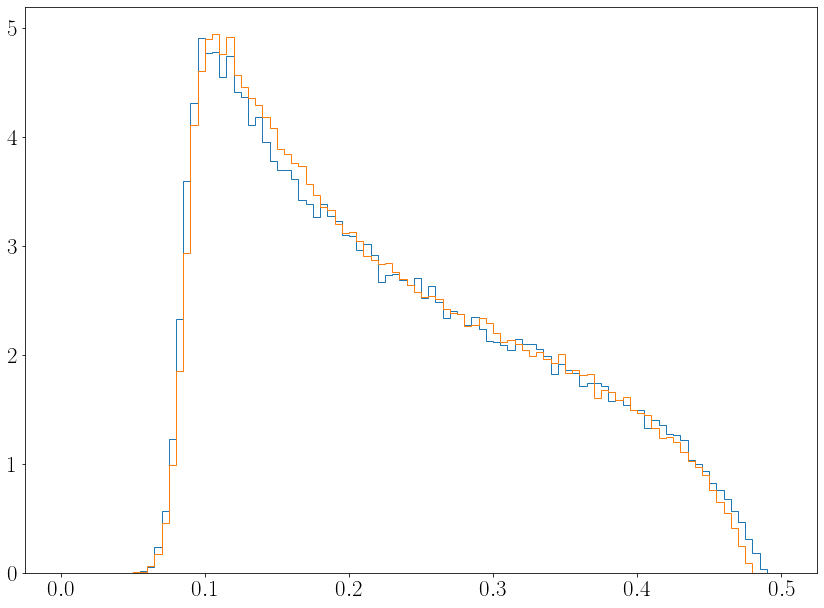

In [337]:
plt.hist((correctDVCS2(epgExpInbCDFT, 0.01, -0.26, 0).Ppx) **2+(correctDVCS2(epgExpInbCDFT, 0.01, -0.36, 0).Ppy )**2, bins = np.linspace(0, 0.5, 101), density = True, histtype = 'step')
plt.hist(dvcsSimInbCDFT.Ppx**2+dvcsSimInbCDFT.Ppy**2, bins = np.linspace(0, 0.5, 101), density = True, histtype = 'step')
plt.show()

<AxesSubplot:>

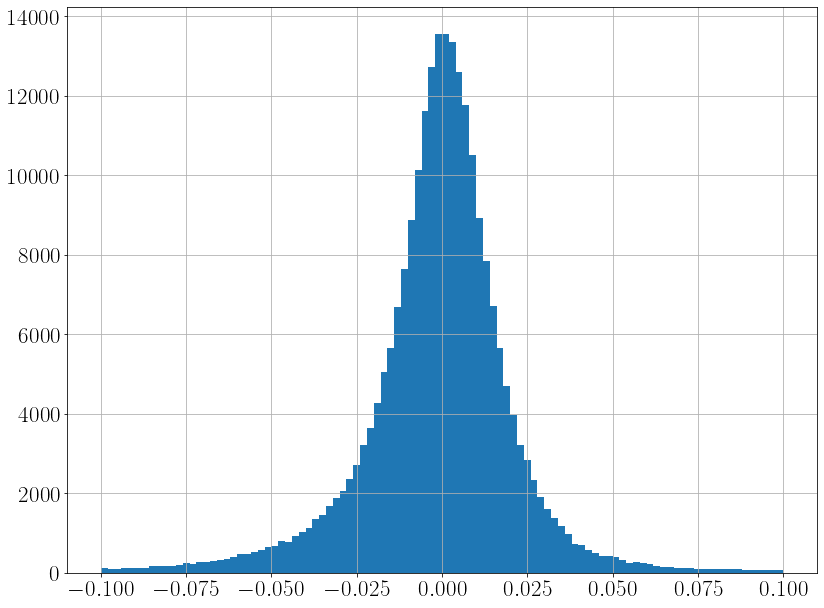

In [170]:
((dvcsSimInbCDFT.Ppx**2  + dvcsSimInbCDFT.Ppy**2 ) - (dvcsSimInbCDFT.GenPpx**2 + dvcsSimInbCDFT.GenPpy**2)).hist(bins = np.linspace(-0.1, 0.1, 101))

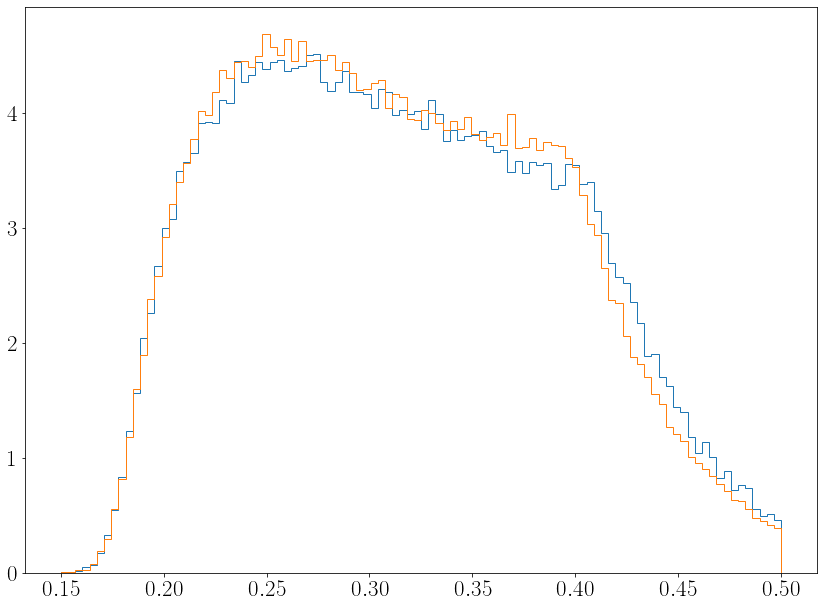

In [338]:
plt.hist(correctDVCS2(epgExpInbCDFT, 0.01, -0.26, 0).Ppz, bins = np.linspace(0.15, 0.5, 101), density = True, histtype = 'step')
plt.hist(dvcsSimInbCDFT.Ppz, bins = np.linspace(0.15, 0.5, 101), density = True, histtype = 'step')
plt.show()

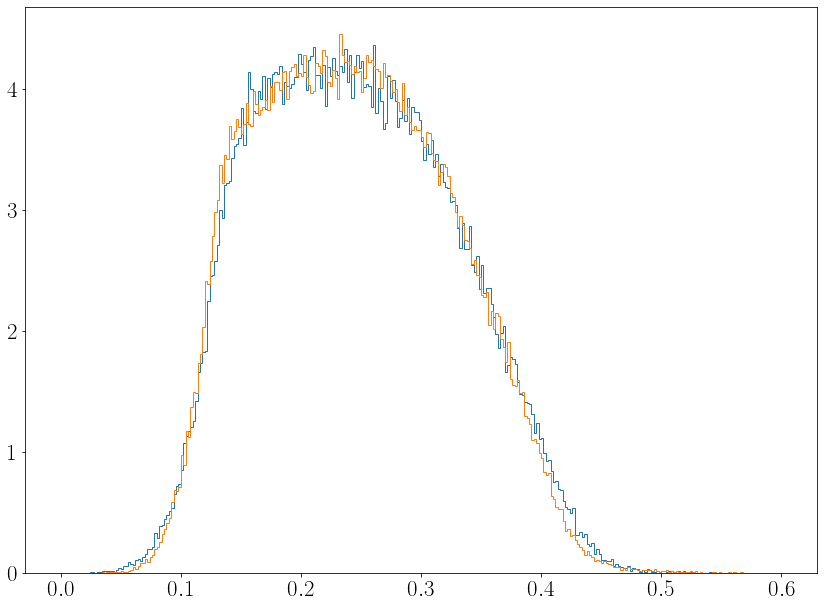

In [339]:
plt.hist((correctDVCS2(epgExpInbCDFT, 0.01, -0.26, 0).Gpx) **2+(correctDVCS2(epgExpInbCDFT, 0.01, -0.36, 0).Gpy )**2, bins = np.linspace(0, 0.6, 301), density = True, histtype = 'step')
plt.hist((dvcsSimInbCDFT.Gpx)**2+(dvcsSimInbCDFT.Gpy)**2, bins = np.linspace(0, 0.6, 301), density = True, histtype = 'step')
plt.show()

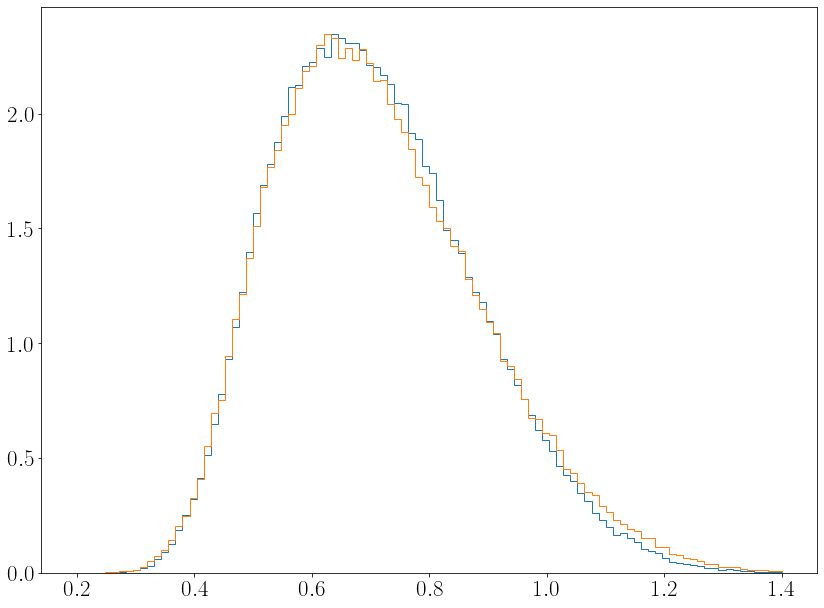

In [388]:
plt.hist((dvcsSimInbCDFT.Epx)**2+(dvcsSimInbCDFT.Epy)**2, bins = np.linspace(0.2, 1.4, 101), density = True, histtype = 'step')
plt.hist((epgExpInbCDFT.Epx)**2+(epgExpInbCDFT.Epy)**2, bins = np.linspace(0.2, 1.4, 101), density = True, histtype = 'step')
plt.show()

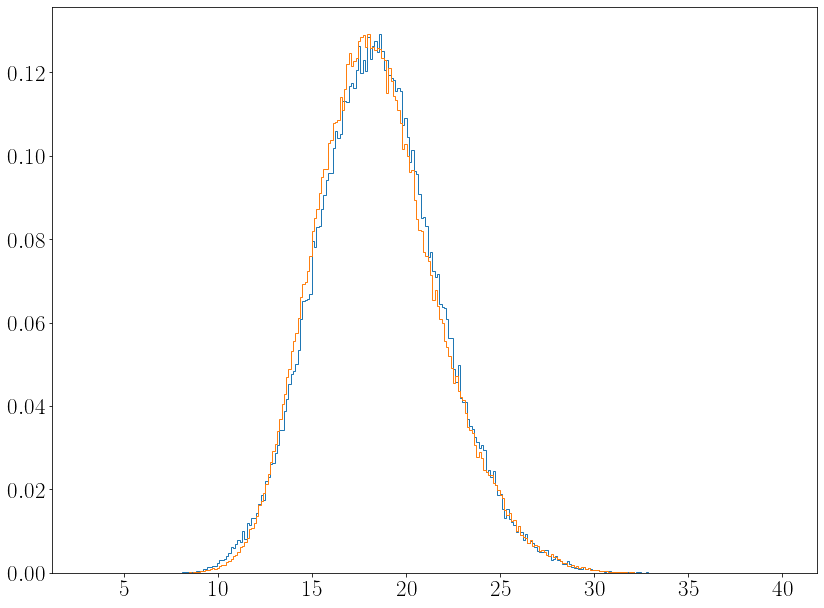

In [385]:
plt.hist(epgExpInbCDFT.Etheta, bins = np.linspace(3, 40, 301), density = True, histtype = 'step')
plt.hist(smearingDVCS(dvcsSimInbCDFT, 0.05, 0, 0).Etheta, bins = np.linspace(3, 40, 301), density = True, histtype = 'step')
plt.show()

In [760]:
ver = "CDcorr"

parent_MC = "/Volumes/Extreme SSD/nov2021/convPkl_"+ver+"/dvcs/"
parent_MC_bkg1g = "/Volumes/Extreme SSD/nov2021/convPkl_"+ver+"/bkg_1g/"
parent_MC_bkg2g = "/Volumes/Extreme SSD/nov2021/convPkl_"+ver+"/bkg_2g/"
parent_exp = "/Volumes/Extreme SSD/nov2021/convPkl_"+ver+"/exp/"

df_3987_corr = pd.read_pickle(parent_MC + "3987.pkl")
df_4076_1g_corr = pd.read_pickle(parent_MC_bkg1g + "4076.pkl")
df_4076_2g_corr = pd.read_pickle(parent_MC_bkg2g + "4076.pkl")
exp_1g_corr = pd.read_pickle(parent_exp + "dvcs_050.pkl")
exp_2g_corr = pd.read_pickle(parent_exp + "pi0_050.pkl")

In [761]:
epgExpInb = copy(exp_1g_corr)
pi0ExpInb = copy(exp_2g_corr)
dvcsSimInb = copy(df_3987_corr)
bkgSimInb = copy(df_4076_1g_corr)
pi0SimInb = copy(df_4076_2g_corr)

In [762]:
epgExpInbCDFT = epgExpInb.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector>7)]
pi0ExpInbCDFT = pi0ExpInb.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>3)&(exp_2g_corr.Pp>0.25)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector>7)&(exp_2g_corr.Ptheta<60))& (exp_2g_corr.Gsector>7)& (exp_2g_corr.Gsector2>7)]
dvcsSimInbCDFT = dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>3)&(dvcsSimInb.Pp>0.25)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector>7)&(dvcsSimInb.Ptheta<60))& (dvcsSimInb.Gsector>7)]
bkgSimInbCDFT = bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>3)&(bkgSimInb.Pp>0.25)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector>7)&(bkgSimInb.Ptheta<60))& (bkgSimInb.Gsector>7)]
pi0SimInbCDFT = pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>3)&(pi0SimInb.Pp>0.25)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector>7)&(pi0SimInb.Ptheta<60))& (pi0SimInb.Gsector>7)]

In [622]:
# exp_1g_corr = pd.read_pickle(parent_exp + "dvcs_026.pkl")
# epgExpInb = copy(exp_1g_corr)
# epgExpInbCDFT_026 = epgExpInb.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector>7)]

# exp_1g_corr = pd.read_pickle(parent_exp + "dvcs_040.pkl")
# epgExpInb = copy(exp_1g_corr)
# epgExpInbCDFT_040 = epgExpInb.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector>7)]

# exp_1g_corr = pd.read_pickle(parent_exp + "dvcs_050.pkl")
# epgExpInb = copy(exp_1g_corr)
# epgExpInbCDFT_050 = epgExpInb.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector>7)]

# exp_1g_corr = pd.read_pickle(parent_exp + "dvcs_060.pkl")
# epgExpInb = copy(exp_1g_corr)
# epgExpInbCDFT_060 = epgExpInb.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector>7)]

# exp_1g_corr = pd.read_pickle(parent_exp + "dvcs_075.pkl")
# epgExpInb = copy(exp_1g_corr)
# epgExpInbCDFT_075 = epgExpInb.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector>7)]


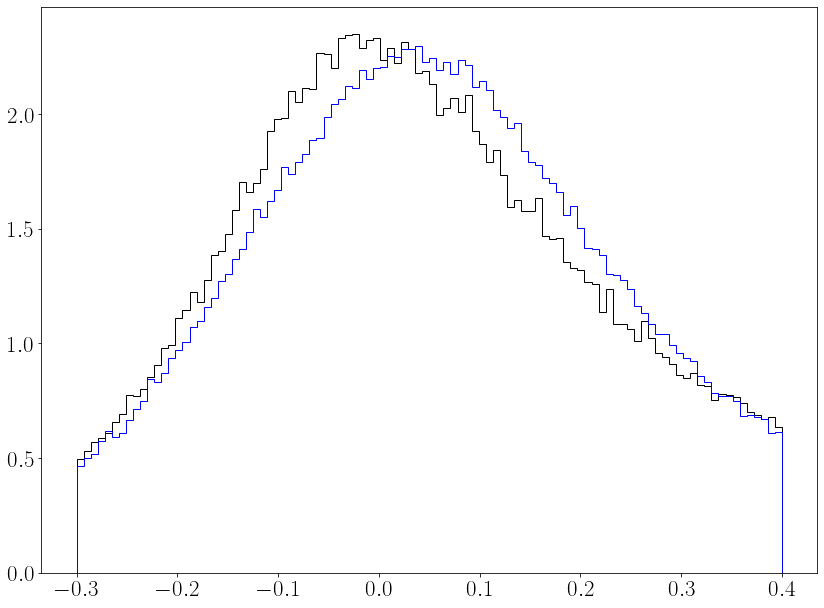

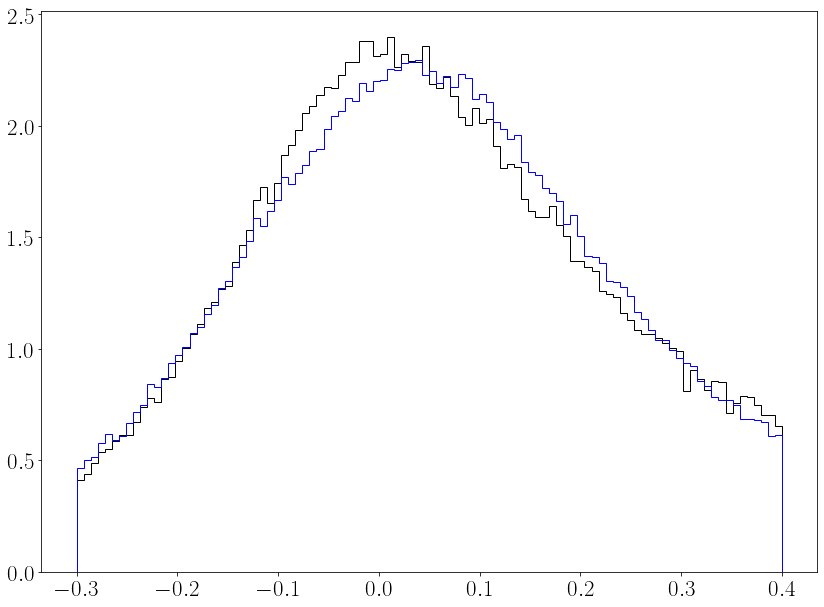

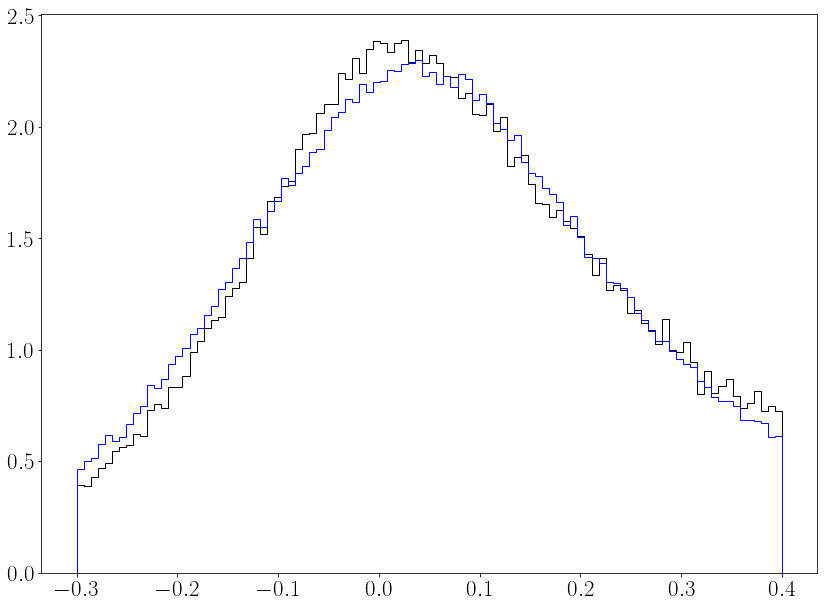

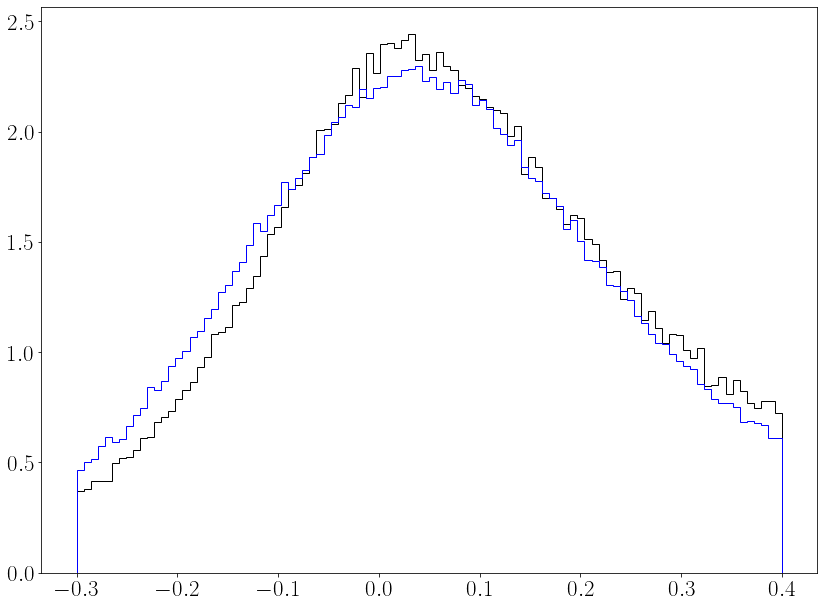

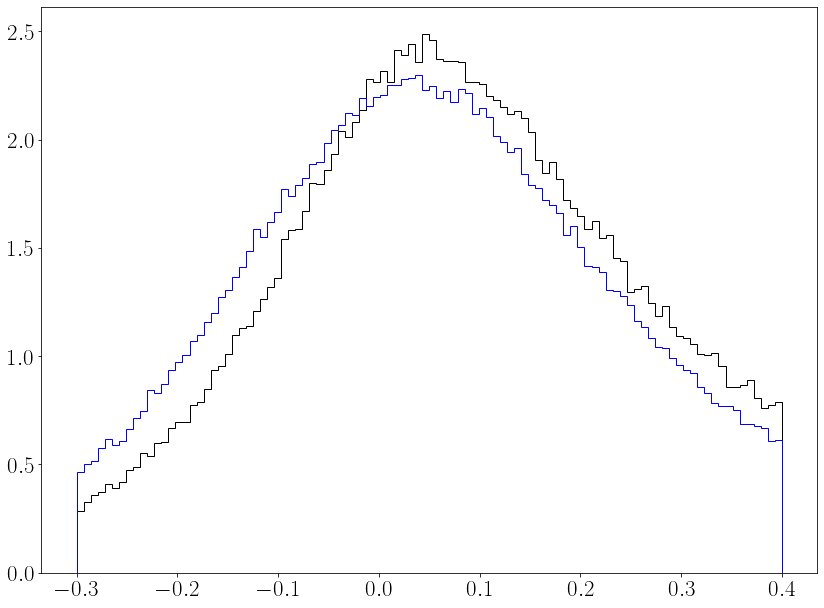

In [625]:
var = "MM2_ep"
co = ['r', 'b', 'r']
ind = 0
for mm2_ep in [epgExpInbCDFT_026[var], epgExpInbCDFT_040[var], epgExpInbCDFT_050[var], epgExpInbCDFT_060[var], epgExpInbCDFT_075[var]]:
    plt.hist(mm2_ep, bins = np.linspace(-0.3, 0.4, 101), density = True, histtype = 'step', color = 'k')
    plt.hist(dvcsSimInbCDFT[var], bins = np.linspace(-0.3, 0.4, 101), density = True, histtype = 'step', color = 'b')
    plt.show()

In [626]:
from scipy.stats import entropy

In [634]:
dvcsSimInbCDFT[var].mean()

0.06234759328207878

In [635]:
var = "MM2_ep"
for mm2_ep in [epgExpInbCDFT_026[var], epgExpInbCDFT_040[var], epgExpInbCDFT_050[var], epgExpInbCDFT_060[var], epgExpInbCDFT_075[var]]:
    hist1 = np.histogram(mm2_ep, bins = np.linspace(dvcsSimInbCDFT[var].mean()-dvcsSimInbCDFT[var].std(), dvcsSimInbCDFT[var].mean()+dvcsSimInbCDFT[var].std(), 101))[0]
    hist2 = np.histogram(dvcsSimInbCDFT[var], bins = np.linspace(dvcsSimInbCDFT[var].mean()-dvcsSimInbCDFT[var].std(), dvcsSimInbCDFT[var].mean()+dvcsSimInbCDFT[var].std(), 101))[0]
    print(entropy(hist1, hist2))

0.007227881210006896
0.0027016653791161103
0.0012420029509243656
0.0017366176610069915
0.005891103901575558


Pp
Ptheta
Pphi
reconGam
coplanarity
ME_epg
MM2_epg
MM2_ep
MPt


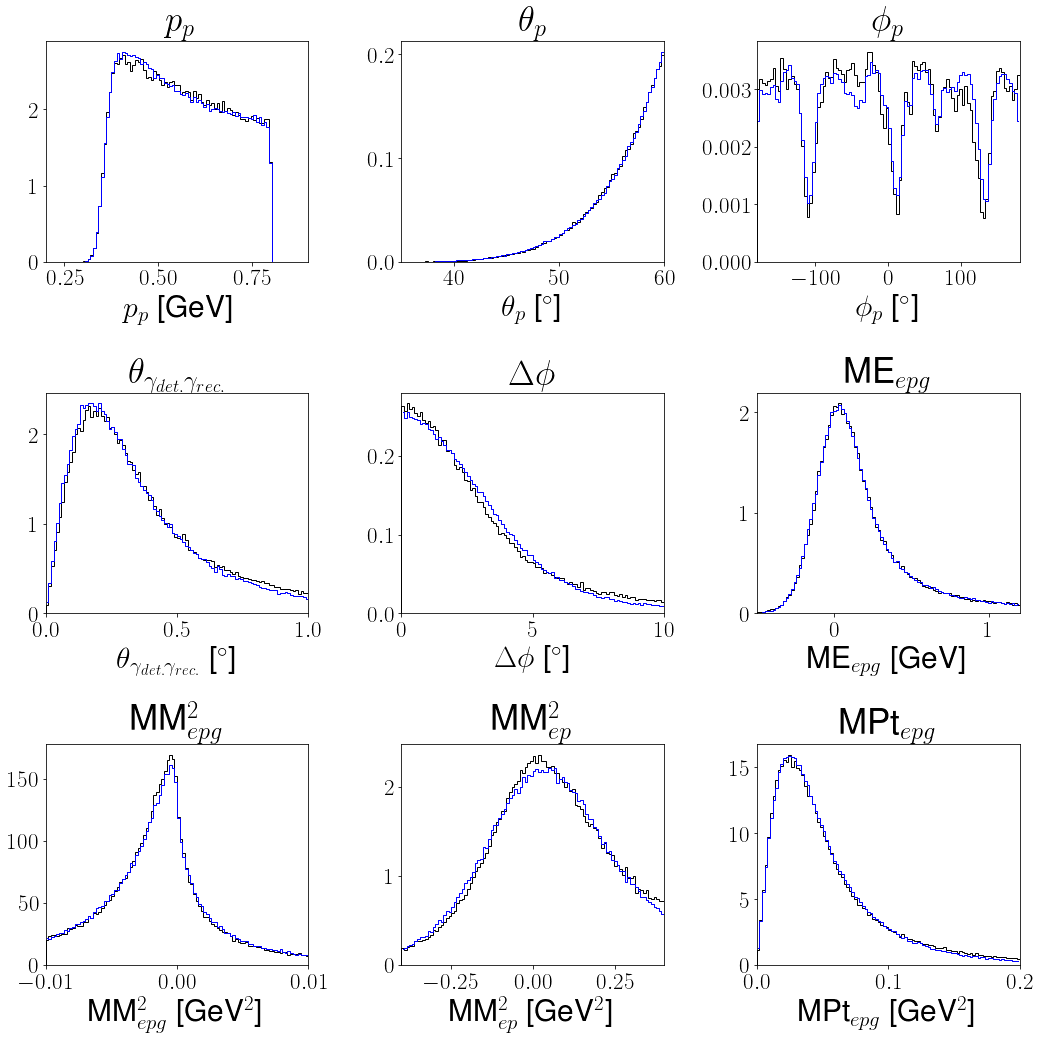

<Figure size 864x648 with 0 Axes>

In [708]:
#proton related
varstoplot = ["Pp", "Ptheta", "Pphi",  "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_ep", "MPt"]
title = [r"$p_{p}$", r"$\theta_{p}$", r"$\phi_{p}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [0.2, 35, -180, 0, 0, -0.5, -0.01, -0.4, 0]
binends = [0.9, 60, 180, 1, 10, 1.2, 0.01, 0.4, 0.2]
fig, axs = plt.subplots(3, 3, figsize = (15,15))
for yind in range(0, 3):
    for xind in range(0,3):
        ind = 3*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
#         simDist_dvpi0, bins = np.histogram(smearingDVCS2(bkgSimInbCDFT, 0.5*bkgSimInbCDFT.Pp**2, 0.7, 2.2)[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbCDFT[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0 + (len_epgExpInbCDFT/len_dvcsSimInbCDFT-len_bkgSimInbCDFT/len_pi0SimInbCDFT*len_pi0ExpInbCDFT/len_dvcsSimInbCDFT)*simDist_dvcs
#         simDist = (1-contCDFT)*simDist_dvcs + contCDFT*simDist_dvpi0
        simDist = simDist_dvcs
#         expDist, bins = np.histogram(correctDVCS(epgExpInbCDFT, 0.25)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCDFT-cont_inb_CDFT/len_dvcsSimInbCDFT)*len_epgExpInbCDFT*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind])#, nphistmean(expDist - len(pi0ExpInbCDFT)/len(pi0SimInbCDFT)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCDFT.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

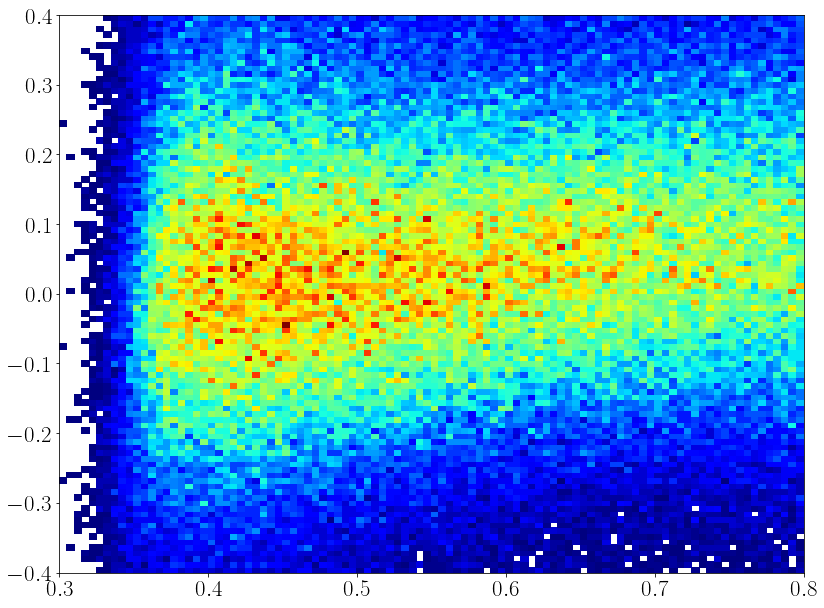

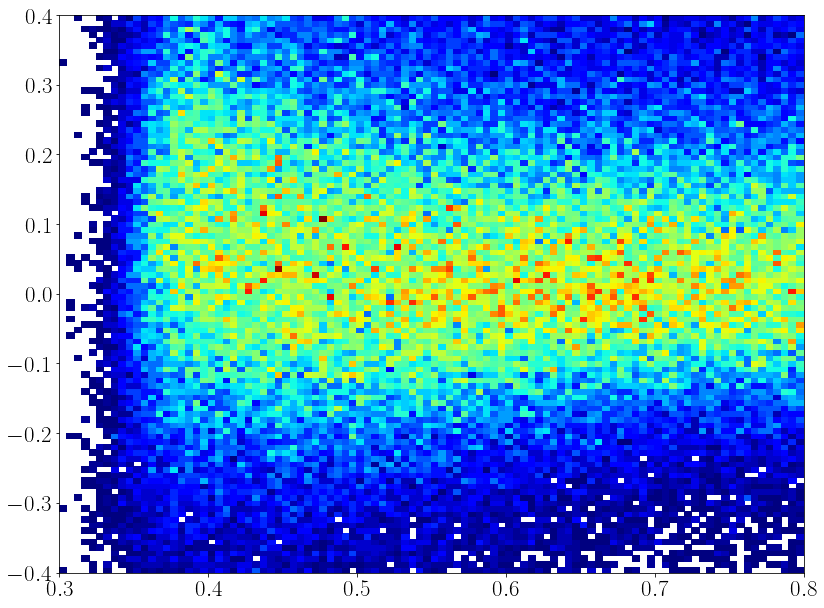

In [650]:
plt.hist2d(dvcsSimInbCDFT.Pp, dvcsSimInbCDFT.MM2_ep, bins = [np.linspace(0.3, 0.8, 101), np.linspace(-0.4, 0.4, 101)], cmap = cmap, cmin = 1)
plt.show()
plt.hist2d(epgExpInbCDFT.Pp, epgExpInbCDFT.MM2_ep, bins = [np.linspace(0.3, 0.8, 101), np.linspace(-0.4, 0.4, 101)], cmap = cmap, cmin = 1)
plt.show()

In [763]:
epgExpInbCD = copy(exp_1g_corr.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector<7)])
pi0ExpInbCD = copy(exp_2g_corr.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>3)&(exp_2g_corr.Pp>0.25)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector>7)&(exp_2g_corr.Ptheta<60))& (exp_2g_corr.Gsector<7)& (exp_2g_corr.Gsector2<7)])
dvcsSimInbCD = copy(dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>3)&(dvcsSimInb.Pp>0.25)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector>7)&(dvcsSimInb.Ptheta<60))& (dvcsSimInb.Gsector<7)])
bkgSimInbCD = copy(bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>3)&(bkgSimInb.Pp>0.25)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector>7)&(bkgSimInb.Ptheta<60))& (bkgSimInb.Gsector<7)])
pi0SimInbCD = copy(pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>3)&(pi0SimInb.Pp>0.25)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector>7)&(pi0SimInb.Ptheta<60))& (pi0SimInb.Gsector<7)])


In [764]:
contCD = len(pi0ExpInbCD)*len(bkgSimInbCD)/len(pi0SimInbCD)/len(epgExpInbCD)

In [765]:
print(contCD)

0.15642521131506681


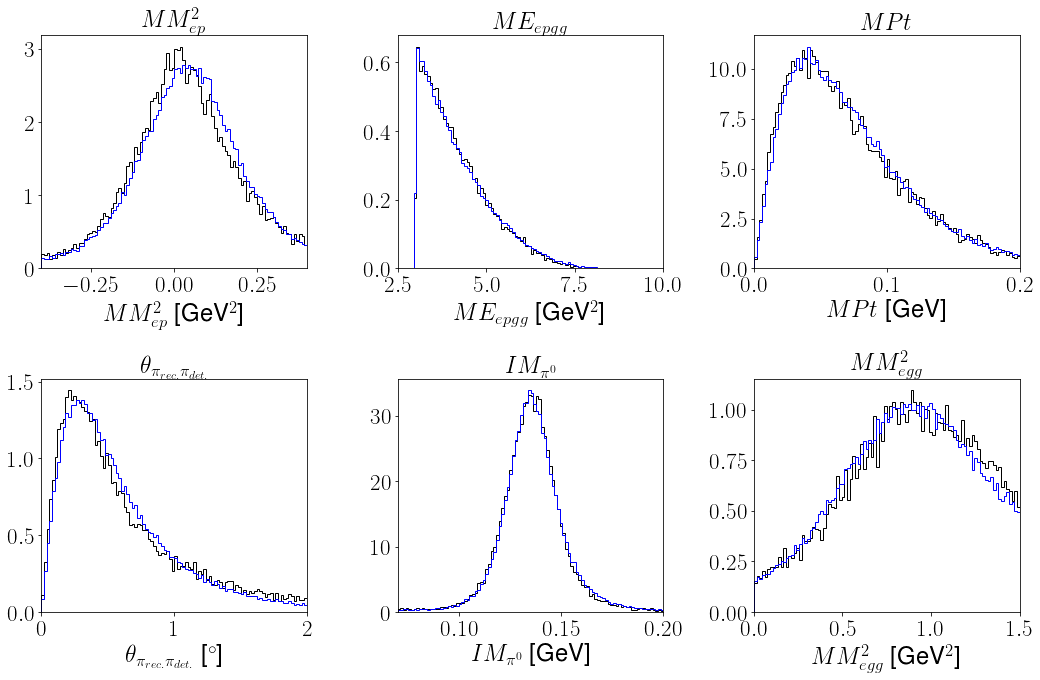

In [808]:
varstoplot = ["MM2_ep", "Gp", "MPt", "reconPi", "Mpi0", "MM2_egg"]
title = [r"$MM^{2}_{ep}$", r"$ME_{epgg}$", r"$MPt$", r"$\theta_{\pi_{rec.}\pi_{det.}}$", r"$IM_{\pi^0}$", r"$MM^2_{egg}$" ]
unit = [GeV2, GeV2, GeV, degree, GeV, GeV2, GeV, "cm"]
binstarts = [-0.4, 2.5, 0, 0, 0.07, 0]
binends = [0.4, 10, 0.2, 2, 0.2, 1.5]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        axs[yind, xind].hist(pi0ExpInbCD.loc[:, varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
        axs[yind, xind].hist(pi0SimInbCD.loc[:, varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='b', density=True, linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
plt.show()

Pp
Ptheta
Pphi
reconGam
coplanarity
ME_epg
MM2_epg
MM2_ep
MPt


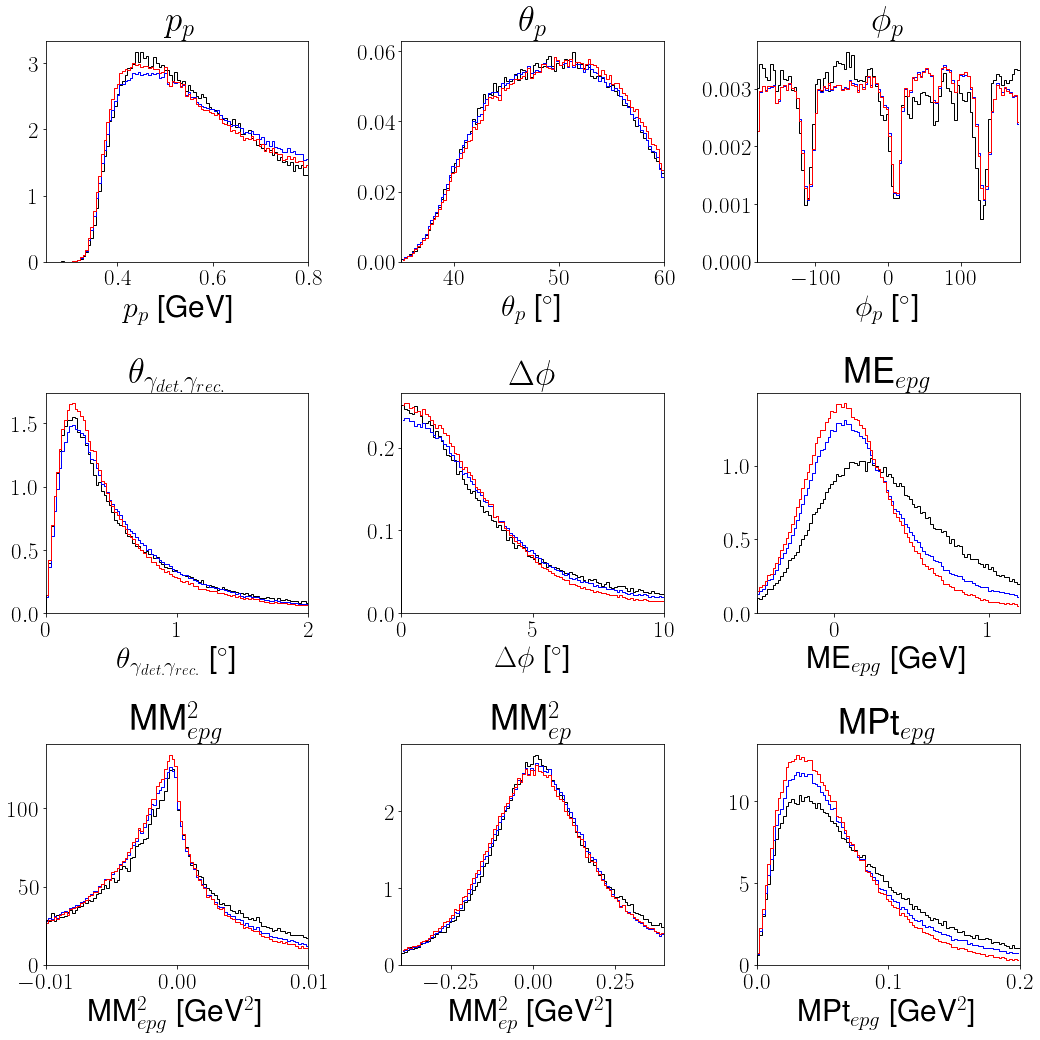

<Figure size 864x648 with 0 Axes>

In [707]:
#proton related
varstoplot = ["Pp", "Ptheta", "Pphi",  "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_ep", "MPt"]
title = [r"$p_{p}$", r"$\theta_{p}$", r"$\phi_{p}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [0.25, 35, -180, 0, 0, -0.5, -0.01, -0.4, 0]
binends = [0.8, 60, 180, 2, 10, 1.2, 0.01, 0.4, 0.2]
fig, axs = plt.subplots(3, 3, figsize = (15,15))
for yind in range(0, 3):
    for xind in range(0,3):
        ind = 3*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbCD[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbCD[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0 + (len_epgExpInbCDFT/len_dvcsSimInbCDFT-len_bkgSimInbCDFT/len_pi0SimInbCDFT*len_pi0ExpInbCDFT/len_dvcsSimInbCDFT)*simDist_dvcs
        simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
#         simDist = simDist_dvcs
#         expDist, bins = np.histogram(correctDVCS(epgExpInbCDFT, 0.25)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCDFT-cont_inb_CDFT/len_dvcsSimInbCDFT)*len_epgExpInbCDFT*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(correctDVCS2(epgExpInbCD, 0, 0, 0)[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind])#, nphistmean(expDist - len(pi0ExpInbCDFT)/len(pi0SimInbCDFT)*simDist_dvpi0, bins))
        axs[yind, xind].step(bincenters, simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCDFT.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

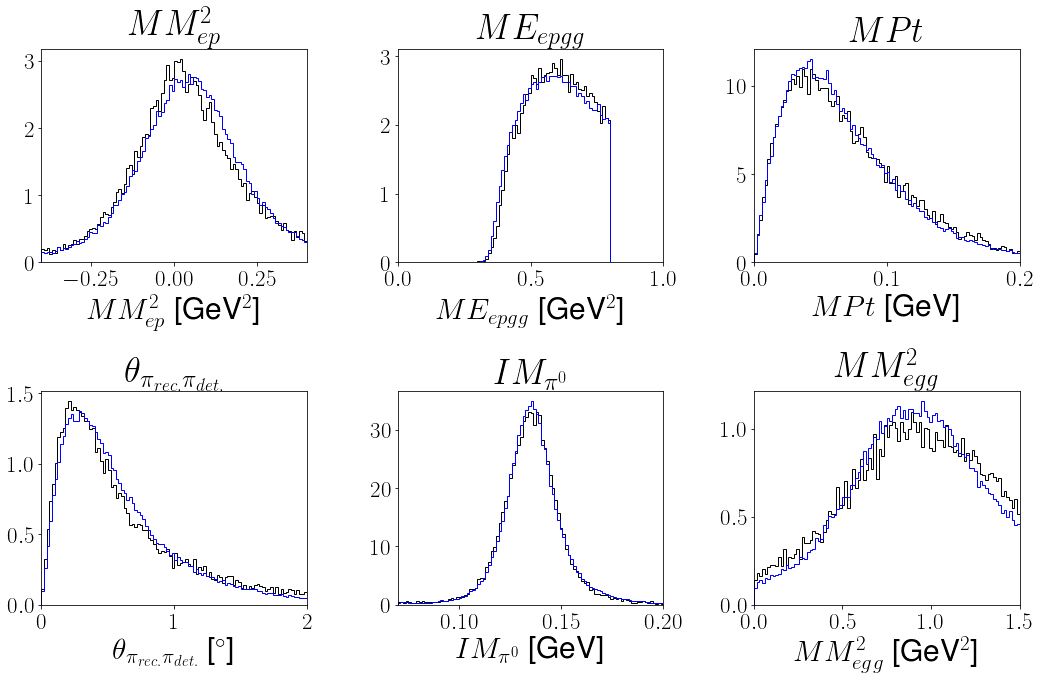

In [703]:
varstoplot = ["MM2_ep", "Pp", "MPt", "reconPi", "Mpi0", "MM2_egg"]
title = [r"$MM^{2}_{ep}$", r"$ME_{epgg}$", r"$MPt$", r"$\theta_{\pi_{rec.}\pi_{det.}}$", r"$IM_{\pi^0}$", r"$MM^2_{egg}$" ]
unit = [GeV2, GeV2, GeV, degree, GeV, GeV2, GeV, "cm"]
binstarts = [-0.4, 0, 0, 0, 0.07, 0]
binends = [0.4, 1, 0.2, 2, 0.2, 1.5]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        axs[yind, xind].hist(pi0ExpInbCD.loc[:, varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
        axs[yind, xind].hist(pi0SimInbCD.loc[:, varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='b', density=True, linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
plt.show()

nu 6.052330548133103
xB 0.22488153960590299
W 3.1676130155757547
t2 0.2859387530068172
Q2 2.5735070137418155
phi2 151.38990600481984


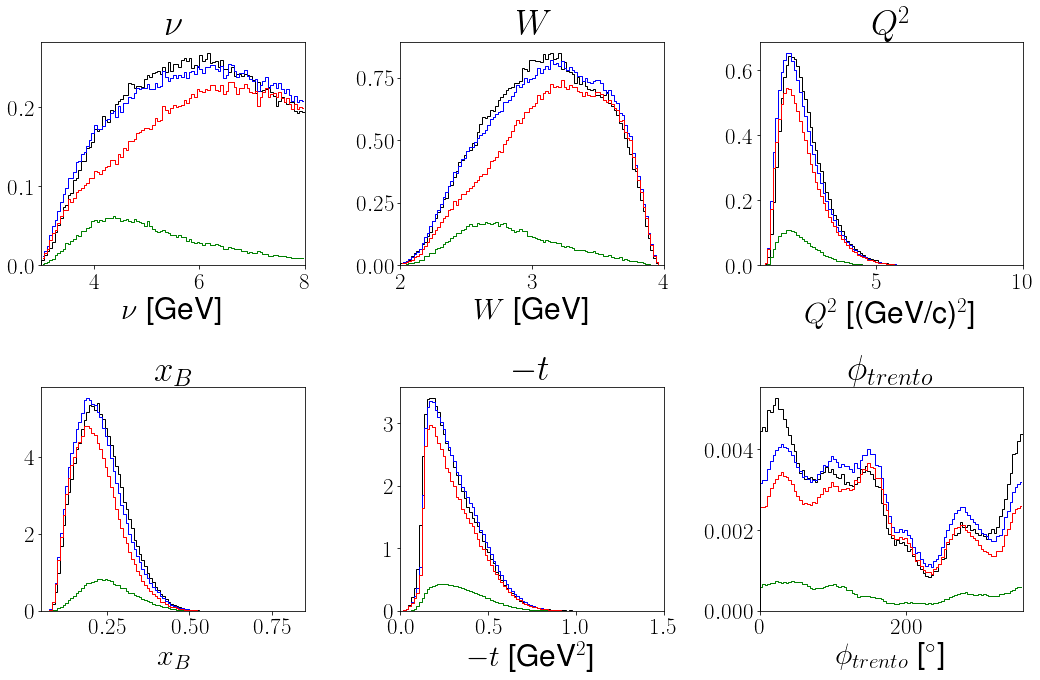

<Figure size 864x648 with 0 Axes>

In [658]:
varstoplot = ["nu", "W", "Q2", "xB", "t2", "phi2"]
title = [r"$\nu$", r"$W$", r"$Q^{2}$", r"$x_{B}$", r"$-t$", r"$\phi_{trento}$" ]
unit = [GeV, GeV, GeVc2, None, GeV2, degree, GeV2, degree]
binstarts = [3, 2, 1, 0.05, 0, 0]
binends = [8, 4, 10, 0.85, 1.5, 360]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbCD[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbCD[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCD/len_pi0SimInbCD*simDist_dvpi0 + (len_epgExpInbCD/len_dvcsSimInbCD-len_bkgSimInbCD/len_pi0SimInbCD*len_pi0ExpInbCD/len_dvcsSimInbCD)*simDist_dvcs
        simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbCD[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
        axs[yind, xind].step(bincenters, contCD*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCD-cont_inb_FD/len_dvcsSimInbCD)*len_epgExpInbCD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbCD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCD/len_pi0SimInbCD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbCD)/len(pi0SimInbCD)*simDist_dvpi0, bins))
        axs[yind, xind].step(bincenters, (1-contCD)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineFD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
correction = 0.005*epgExpInbCD.Gp*2
plt.clf()

In [906]:
def correctDVCS3(df_epg, correction1 = 0, correction2 = 0, correction3 =0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
#     df_epg.loc[:, 'Pp'] = mag(pro)
#     df_epg.loc[:, 'Pe'] = getEnergy(pro, 0)
#     df_epg.loc[:, 'Ptheta'] = getTheta(pro)
#     df_epg.loc[:, 'Pphi'] = getPhi(pro)

    Sampl = df_epg.loc[df_epg.Gsector<7, 'Gedep']/df_epg.loc[df_epg.Gsector<7, 'Gp']
    df_epg.loc[df_epg.Gsector<7, 'Gedep1'] = df_epg.loc[df_epg.Gsector<7, 'Gedep1'] + correction1
    df_epg.loc[df_epg.Gsector<7, 'Gedep2'] = df_epg.loc[df_epg.Gsector<7, 'Gedep2'] + correction2
    df_epg.loc[df_epg.Gsector<7, 'Gedep3'] = df_epg.loc[df_epg.Gsector<7, 'Gedep3'] + correction3
    df_epg.loc[df_epg.Gsector<7, 'Gedep'] = df_epg.loc[df_epg.Gsector<7, 'Gedep1'] + df_epg.loc[df_epg.Gsector<7, 'Gedep2'] + df_epg.loc[df_epg.Gsector<7, 'Gedep3']
    df_epg.loc[df_epg.Gsector<7, 'Gp'] = df_epg.loc[df_epg.Gsector<7, 'Gedep']/Sampl

#     df_epg.loc[df_epg.Gsector<7, 'Gp'] = df_epg.loc[df_epg.Gsector<7, 'Gp'] + correction
    df_epg.loc[df_epg.Gsector<7, 'Ge'] = df_epg.loc[df_epg.Gsector<7, 'Gp']
#     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
#     df_epg.loc[:, 'Gphi'] = getPhi(gam)
    df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]

    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


In [11]:
def smearingDVCS3(df_epg, sigma = 0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
#     df_epg.loc[:, 'Pp'] = mag(pro)
#     df_epg.loc[:, 'Pe'] = getEnergy(pro, 0)
#     df_epg.loc[:, 'Ptheta'] = getTheta(pro)
#     df_epg.loc[:, 'Pphi'] = getPhi(pro)

    df_epg.loc[df_epg.Gsector<7, 'Gp'] = np.random.normal(1, sigma, len(df_epg.loc[df_epg.Gsector<7]))*df_epg.loc[df_epg.Gsector<7, 'Gp']
    df_epg.loc[df_epg.Gsector<7, 'Ge'] = df_epg.loc[df_epg.Gsector<7, 'Gp']
#     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
#     df_epg.loc[:, 'Gphi'] = getPhi(gam)
    df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]
    
    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


In [805]:
contCD = len(pi0ExpInbCD)*len(bkgSimInbCD)/len(pi0SimInbCD)/len(epgExpInbCD)

In [873]:
contCD

0.15819901911233836

Gp
Gtheta
Gphi
coneAngle
reconGam
t2
ME_epg
MM2_epg
MM2_eg
coplanarity


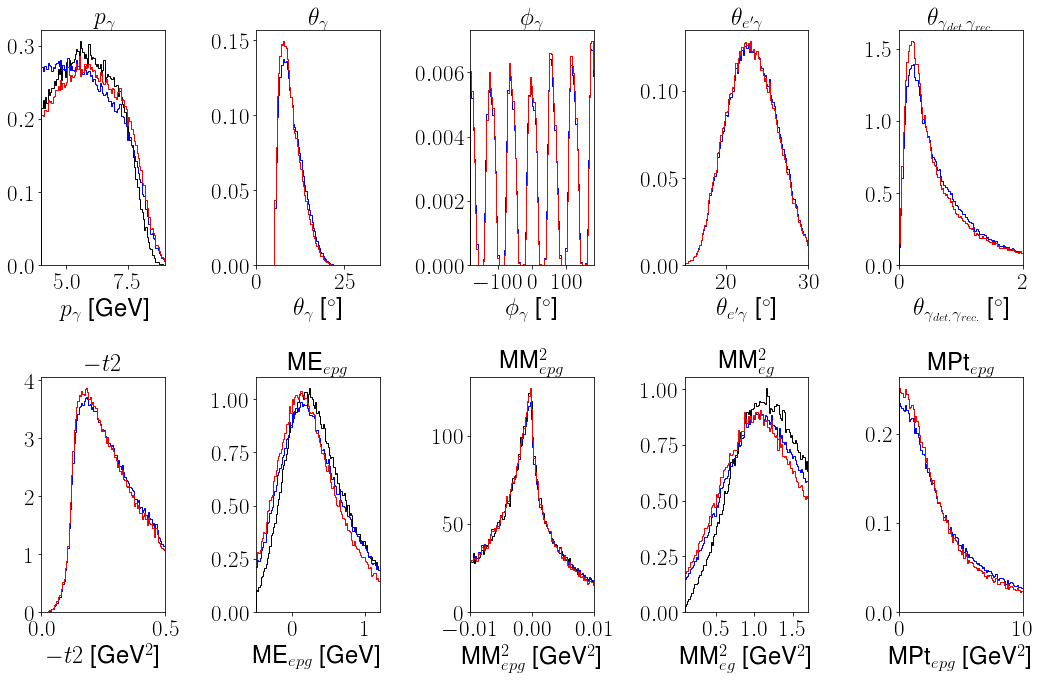

<Figure size 432x288 with 0 Axes>

In [878]:
df1 = dvcsSimInbCD#smearingDVCS3(dvcsSimInbCD, 0.035)
df2 = bkgSimInbCD#smearingDVCS3(bkgSimInbCD, 0.035)
correction = 0#0.0045*epgExpInbCD.Gp*epgExpInbCD.Gp

#photon related
varstoplot = ["Gp", "Gtheta", "Gphi", "coneAngle",  "reconGam", "t2", "ME_epg", "MM2_epg", "MM2_eg", "coplanarity"]
title = [r"$p_{\gamma}$", r"$\theta_{\gamma}$", r"$\phi_{\gamma}$", r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$-t2$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, GeV2, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [4, 0, -180, 15, 0, 0, -0.5, -0.01, 0.1, 0]
binends = [9, 35, 180, 30, 2, .5, 1.2, 0.01, 1.7, 10]
fig, axs = plt.subplots(2, 5, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,5):
        ind = 5*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(df2[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(df[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0 + (len_epgExpInbCDFT/len_dvcsSimInbCDFT-len_bkgSimInbCDFT/len_pi0SimInbCDFT*len_pi0ExpInbCDFT/len_dvcsSimInbCDFT)*simDist_dvcs
        simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
#         expDist, bins = np.histogram(correctDVCS(epgExpInbCDFT, 0.25)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCDFT-cont_inb_CDFT/len_dvcsSimInbCDFT)*len_epgExpInbCDFT*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(correctDVCS3(epgExpInbCD, correction)[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind])#, nphistmean(expDist - len(pi0ExpInbCDFT)/len(pi0SimInbCDFT)*simDist_dvpi0, bins))
        axs[yind, xind].step(bincenters, simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCDFT.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

## FD photon correction

In [973]:
ver = "FDphoton"

parent_MC = "/Volumes/Extreme SSD/nov2021/convPkl_"+ver+"/dvcs/"
parent_MC_bkg1g = "/Volumes/Extreme SSD/nov2021/convPkl_"+ver+"/bkg_1g/"
parent_MC_bkg2g = "/Volumes/Extreme SSD/nov2021/convPkl_"+ver+"/bkg_2g/"
parent_exp = "/Volumes/Extreme SSD/nov2021/convPkl_"+ver+"/exp/"

df_3987_corr = pd.read_pickle(parent_MC + "3987.pkl")
df_4076_1g_corr = pd.read_pickle(parent_MC_bkg1g + "4076.pkl")
df_4076_2g_corr = pd.read_pickle(parent_MC_bkg2g + "4076.pkl")
# exp_1g_corr = pd.read_pickle(parent_exp + "dvcs.pkl")
# exp_2g_corr = pd.read_pickle(parent_exp + "pi0.pkl")
# exp_1g_corr = pd.read_pickle(parent_exp + "dvcs.pkl")
# exp_2g_corr = pd.read_pickle(parent_exp + "pi0.pkl")

In [776]:
epgExpInb = copy(exp_1g_corr)
pi0ExpInb = copy(exp_2g_corr)
dvcsSimInb = copy(df_3987_corr)
bkgSimInb = copy(df_4076_1g_corr)
pi0SimInb = copy(df_4076_2g_corr)

In [777]:
epgExpInbCD = copy(epgExpInb.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector<7)])
pi0ExpInbCD = copy(pi0ExpInb.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>3)&(exp_2g_corr.Pp>0.25)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector>7)&(exp_2g_corr.Ptheta<60))& (exp_2g_corr.Gsector<7)& (exp_2g_corr.Gsector2<7)])
dvcsSimInbCD = copy(dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>3)&(dvcsSimInb.Pp>0.25)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector>7)&(dvcsSimInb.Ptheta<60))& (dvcsSimInb.Gsector<7)])
bkgSimInbCD = copy(bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>3)&(bkgSimInb.Pp>0.25)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector>7)&(bkgSimInb.Ptheta<60))& (bkgSimInb.Gsector<7)])
pi0SimInbCD = copy(pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>3)&(pi0SimInb.Pp>0.25)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector>7)&(pi0SimInb.Ptheta<60))& (pi0SimInb.Gsector<7)])

In [880]:
def correctDVpi0(df, correction):
    #set up pi0 variables

    df = copy(df_epgg)
    
    # useful objects
    ele = [df_epgg['Epx'], df_epgg['Epy'], df_epgg['Epz']]
    df_epgg.loc[:, 'Ep'] = mag(ele)
    df_epgg.loc[:, 'Ee'] = getEnergy(ele, me)
    df_epgg.loc[:, 'Etheta'] = getTheta(ele)
    df_epgg.loc[:, 'Ephi'] = getPhi(ele)

    pro = [df_epgg['Ppx'], df_epgg['Ppy'], df_epgg['Ppz']]

    df_epgg.loc[df_epgg.Gsector>7, 'Gp'] = df_epgg.loc[df_epgg.Gsector>7, 'Gp'] + correction
    df_epgg.loc[df_epgg.Gsector>7, 'Ge'] = df_epgg.loc[df_epgg.Gsector>7, 'Ge'] + correction
#     df_epgg.loc[:, 'Gtheta'] = getTheta(gam)
#     df_epgg.loc[:, 'Gphi'] = getPhi(gam)
    df_epgg.loc[:, "Gpx"] = df_epgg.loc[:, "Gp"]*np.sin(np.radians(df_epgg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epgg.loc[:, "Gphi"]))
    df_epgg.loc[:, "Gpy"] = df_epgg.loc[:, "Gp"]*np.sin(np.radians(df_epgg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epgg.loc[:, "Gphi"]))
    df_epgg.loc[:, "Gpz"] = df_epgg.loc[:, "Gp"]*np.cos(np.radians(df_epgg.loc[:, "Gtheta"]))
    gam = [df_epgg['Gpx'], df_epgg['Gpy'], df_epgg['Gpz']]


    df_epgg.loc[df_epgg.Gsector>7, 'Gp2'] = df_epgg.loc[df_epgg.Gsector>7, 'Gp2'] + correction
    df_epgg.loc[df_epgg.Gsector>7, 'Ge2'] = df_epgg.loc[df_epgg.Gsector>7, 'Ge2'] + correction
#     df_epgg.loc[:, 'Gtheta2'] = getTheta(gam)
#     df_epgg.loc[:, 'Gphi2'] = getPhi(gam)
    df_epgg.loc[:, "Gpx2"] = df_epgg.loc[:, "Gp2"]*np.sin(np.radians(df_epgg.loc[:, "Gtheta2"]))*np.cos(np.radians(df_epgg.loc[:, "Gphi2"]))
    df_epgg.loc[:, "Gpy2"] = df_epgg.loc[:, "Gp2"]*np.sin(np.radians(df_epgg.loc[:, "Gtheta2"]))*np.sin(np.radians(df_epgg.loc[:, "Gphi2"]))
    df_epgg.loc[:, "Gpz2"] = df_epgg.loc[:, "Gp2"]*np.cos(np.radians(df_epgg.loc[:, "Gtheta2"]))
    gam2 = [df_epgg['Gpx2'], df_epgg['Gpy2'], df_epgg['Gpz2']]


    pi0 = vecAdd(gam, gam2)
    VGS = [-df_epgg['Epx'], -df_epgg['Epy'], pbeam - df_epgg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissPi0 = [-df_epgg["Epx"] - df_epgg["Ppx"], -df_epgg["Epy"] -
                df_epgg["Ppy"], pbeam - df_epgg["Epz"] - df_epgg["Ppz"]]
    VmissP = [-df_epgg["Epx"] - df_epgg["Gpx"] - df_epgg["Gpx2"], -df_epgg["Epy"] -
                df_epgg["Gpy"] - df_epgg["Gpy2"], pbeam - df_epgg["Epz"] - df_epgg["Gpz"] - df_epgg["Gpz2"]]
    Vmiss = [-df_epgg["Epx"] - df_epgg["Ppx"] - df_epgg["Gpx"] - df_epgg["Gpx2"],
                -df_epgg["Epy"] - df_epgg["Ppy"] - df_epgg["Gpy"] - df_epgg["Gpy2"],
                pbeam - df_epgg["Epz"] - df_epgg["Ppz"] - df_epgg["Gpz"] - df_epgg["Gpz2"]]
    costheta = cosTheta(VGS, gam)

    df_epgg.loc[:, 'Mpx'], df_epgg.loc[:, 'Mpy'], df_epgg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epgg.loc[:,'Q2'] = -((ebeam - df_epgg['Ee'])**2 - mag2(VGS))
    df_epgg.loc[:,'nu'] = (ebeam - df_epgg['Ee'])
    df_epgg.loc[:,'xB'] = df_epgg['Q2'] / 2.0 / M / df_epgg['nu']
    df_epgg.loc[:,'t1'] = 2 * M * (df_epgg['Pe'] - M)
    df_epgg.loc[:,'t2'] = (M * df_epgg['Q2'] + 2 * M * df_epgg['nu'] * (df_epgg['nu'] - np.sqrt(df_epgg['nu'] * df_epgg['nu'] + df_epgg['Q2']) * costheta))\
    / (M + df_epgg['nu'] - np.sqrt(df_epgg['nu'] * df_epgg['nu'] + df_epgg['Q2']) * costheta)
    df_epgg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epgg['Ee'])**2 - mag2(VGS)))
    df_epgg.loc[:,'MPt'] = np.sqrt((df_epgg["Epx"] + df_epgg["Ppx"] + df_epgg["Gpx"] + df_epgg["Gpx2"])**2 +
                             (df_epgg["Epy"] + df_epgg["Ppy"] + df_epgg["Gpy"] + df_epgg["Gpy2"])**2)
    # trento angles
    df_epgg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epgg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epgg['phi1'], df_epgg['phi1'])
    df_epgg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epgg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epgg['phi2'], df_epgg['phi2'])

    # exclusivity variables
    df_epgg.loc[:,'MM2_ep'] = (-M - ebeam + df_epgg["Ee"] +
                         df_epgg["Pe"])**2 - mag2(VmissPi0)
    df_epgg.loc[:,'MM2_egg'] = (-M - ebeam + df_epgg["Ee"] +
                         df_epgg["Ge"] + df_epgg["Ge2"])**2 - mag2(VmissP)
    df_epgg.loc[:,'MM2_epgg'] = (-M - ebeam + df_epgg["Ee"] + df_epgg["Pe"] +
                         df_epgg["Ge"] + df_epgg["Ge2"])**2 - mag2(Vmiss)
    df_epgg.loc[:,'ME_epgg'] = (M + ebeam - df_epgg["Ee"] - df_epgg["Pe"] - df_epgg["Ge"] - df_epgg["Ge2"])
    df_epgg.loc[:,'Mpi0'] = pi0InvMass(gam, gam2)
    df_epgg.loc[:,'reconPi'] = angle(VmissPi0, pi0)
    df_epgg.loc[:,"Pie"] = df_epgg['Ge'] + df_epgg['Ge2']
    return df_epgg

In [ ]:
def correctDVpi0(df, correction):
    #set up pi0 variables

    df = copy(df_epgg)
    
    # useful objects
    ele = [df_epgg['Epx'], df_epgg['Epy'], df_epgg['Epz']]
    df_epgg.loc[:, 'Ep'] = mag(ele)
    df_epgg.loc[:, 'Ee'] = getEnergy(ele, me)
    df_epgg.loc[:, 'Etheta'] = getTheta(ele)
    df_epgg.loc[:, 'Ephi'] = getPhi(ele)

    pro = [df_epgg['Ppx'], df_epgg['Ppy'], df_epgg['Ppz']]

    Sampl = df_epgg.loc[df_epgg.Gsector>7, 'Gedep']/df_epgg.loc[df_epgg.Gsector>7, 'Gp']
    df_epgg.loc[df_epgg.Gsector>7, 'Gedep1'] = df_epgg.loc[df_epgg.Gsector>7, 'Gedep1'] + correction1
    df_epgg.loc[df_epgg.Gsector>7, 'Gedep2'] = df_epgg.loc[df_epgg.Gsector>7, 'Gedep2'] + correction2
    df_epgg.loc[df_epgg.Gsector>7, 'Gedep3'] = df_epgg.loc[df_epgg.Gsector>7, 'Gedep3'] + correction3
    df_epgg.loc[df_epgg.Gsector>7, 'Gedep'] = df_epgg.loc[df_epgg.Gsector>7, 'Gedep'] + correction1 + correction2 + correction3
    df_epgg.loc[df_epgg.Gsector>7, 'Gp'] = df_epgg.loc[df_epgg.Gsector>7, 'Gedep']/Sampl
    df_epgg.loc[df_epgg.Gsector>7, 'Ge'] = df_epgg.loc[df_epgg.Gsector>7, 'Gp']
#     df_epgg.loc[:, 'Gtheta'] = getTheta(gam)
#     df_epgg.loc[:, 'Gphi'] = getPhi(gam)
    df_epgg.loc[:, "Gpx"] = df_epgg.loc[:, "Gp"]*np.sin(np.radians(df_epgg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epgg.loc[:, "Gphi"]))
    df_epgg.loc[:, "Gpy"] = df_epgg.loc[:, "Gp"]*np.sin(np.radians(df_epgg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epgg.loc[:, "Gphi"]))
    df_epgg.loc[:, "Gpz"] = df_epgg.loc[:, "Gp"]*np.cos(np.radians(df_epgg.loc[:, "Gtheta"]))
    gam = [df_epgg['Gpx'], df_epgg['Gpy'], df_epgg['Gpz']]


    Sampl = df_epgg.loc[df_epgg.Gsector>7, 'Gedep']/df_epgg.loc[df_epgg.Gsector>7, 'Gp']
    df_epgg.loc[df_epgg.Gsector>7, 'Gedep1'] = df_epgg.loc[df_epgg.Gsector>7, 'Gedep1'] + correction1
    df_epgg.loc[df_epgg.Gsector>7, 'Gedep2'] = df_epgg.loc[df_epgg.Gsector>7, 'Gedep2'] + correction2
    df_epgg.loc[df_epgg.Gsector>7, 'Gedep3'] = df_epgg.loc[df_epgg.Gsector>7, 'Gedep3'] + correction3

    df_epgg.loc[df_epgg.Gsector>7, 'Gedep'] = df_epgg.loc[df_epgg.Gsector>7, 'Gedep'] + correction1 + correction2 + correction3
    df_epgg.loc[df_epgg.Gsector>7, 'Gp2'] = df_epgg.loc[df_epgg.Gsector>7, 'Gp2'] + correction1 + correction2 + correction3
    df_epgg.loc[df_epgg.Gsector>7, 'Ge2'] = df_epgg.loc[df_epgg.Gsector>7, 'Gp2']
    df_epgg.loc[:, "Gpx2"] = df_epgg.loc[:, "Gp2"]*np.sin(np.radians(df_epgg.loc[:, "Gtheta2"]))*np.cos(np.radians(df_epgg.loc[:, "Gphi2"]))
    df_epgg.loc[:, "Gpy2"] = df_epgg.loc[:, "Gp2"]*np.sin(np.radians(df_epgg.loc[:, "Gtheta2"]))*np.sin(np.radians(df_epgg.loc[:, "Gphi2"]))
    df_epgg.loc[:, "Gpz2"] = df_epgg.loc[:, "Gp2"]*np.cos(np.radians(df_epgg.loc[:, "Gtheta2"]))
    gam2 = [df_epgg['Gpx2'], df_epgg['Gpy2'], df_epgg['Gpz2']]


    pi0 = vecAdd(gam, gam2)
    VGS = [-df_epgg['Epx'], -df_epgg['Epy'], pbeam - df_epgg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissPi0 = [-df_epgg["Epx"] - df_epgg["Ppx"], -df_epgg["Epy"] -
                df_epgg["Ppy"], pbeam - df_epgg["Epz"] - df_epgg["Ppz"]]
    VmissP = [-df_epgg["Epx"] - df_epgg["Gpx"] - df_epgg["Gpx2"], -df_epgg["Epy"] -
                df_epgg["Gpy"] - df_epgg["Gpy2"], pbeam - df_epgg["Epz"] - df_epgg["Gpz"] - df_epgg["Gpz2"]]
    Vmiss = [-df_epgg["Epx"] - df_epgg["Ppx"] - df_epgg["Gpx"] - df_epgg["Gpx2"],
                -df_epgg["Epy"] - df_epgg["Ppy"] - df_epgg["Gpy"] - df_epgg["Gpy2"],
                pbeam - df_epgg["Epz"] - df_epgg["Ppz"] - df_epgg["Gpz"] - df_epgg["Gpz2"]]
    costheta = cosTheta(VGS, gam)

    df_epgg.loc[:, 'Mpx'], df_epgg.loc[:, 'Mpy'], df_epgg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epgg.loc[:,'Q2'] = -((ebeam - df_epgg['Ee'])**2 - mag2(VGS))
    df_epgg.loc[:,'nu'] = (ebeam - df_epgg['Ee'])
    df_epgg.loc[:,'xB'] = df_epgg['Q2'] / 2.0 / M / df_epgg['nu']
    df_epgg.loc[:,'t1'] = 2 * M * (df_epgg['Pe'] - M)
    df_epgg.loc[:,'t2'] = (M * df_epgg['Q2'] + 2 * M * df_epgg['nu'] * (df_epgg['nu'] - np.sqrt(df_epgg['nu'] * df_epgg['nu'] + df_epgg['Q2']) * costheta))\
    / (M + df_epgg['nu'] - np.sqrt(df_epgg['nu'] * df_epgg['nu'] + df_epgg['Q2']) * costheta)
    df_epgg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epgg['Ee'])**2 - mag2(VGS)))
    df_epgg.loc[:,'MPt'] = np.sqrt((df_epgg["Epx"] + df_epgg["Ppx"] + df_epgg["Gpx"] + df_epgg["Gpx2"])**2 +
                             (df_epgg["Epy"] + df_epgg["Ppy"] + df_epgg["Gpy"] + df_epgg["Gpy2"])**2)
    # trento angles
    df_epgg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epgg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epgg['phi1'], df_epgg['phi1'])
    df_epgg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epgg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epgg['phi2'], df_epgg['phi2'])

    # exclusivity variables
    df_epgg.loc[:,'MM2_ep'] = (-M - ebeam + df_epgg["Ee"] +
                         df_epgg["Pe"])**2 - mag2(VmissPi0)
    df_epgg.loc[:,'MM2_egg'] = (-M - ebeam + df_epgg["Ee"] +
                         df_epgg["Ge"] + df_epgg["Ge2"])**2 - mag2(VmissP)
    df_epgg.loc[:,'MM2_epgg'] = (-M - ebeam + df_epgg["Ee"] + df_epgg["Pe"] +
                         df_epgg["Ge"] + df_epgg["Ge2"])**2 - mag2(Vmiss)
    df_epgg.loc[:,'ME_epgg'] = (M + ebeam - df_epgg["Ee"] - df_epgg["Pe"] - df_epgg["Ge"] - df_epgg["Ge2"])
    df_epgg.loc[:,'Mpi0'] = pi0InvMass(gam, gam2)
    df_epgg.loc[:,'reconPi'] = angle(VmissPi0, pi0)
    df_epgg.loc[:,"Pie"] = df_epgg['Ge'] + df_epgg['Ge2']
    return df_epgg

3.0 3.5


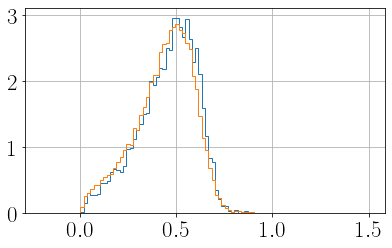

3.5 4.0


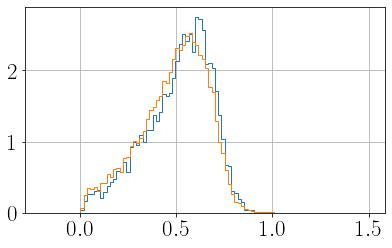

4.0 4.5


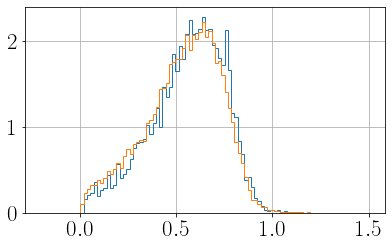

4.5 5.0


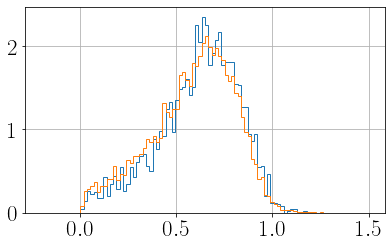

5.0 5.5


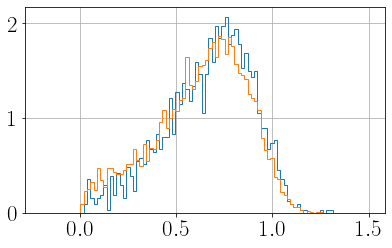

In [904]:
j = 0.5
ind = 0
det = [-0.02, -0.02, -0.02, -0.02, -0.02, -0.02]
for i in np.linspace(3, 5, (5-3)*2+1):
    print(i, i+j)
    exp = pi0ExpInbCD.loc[(pi0ExpInbCD.Gp>i) & (pi0ExpInbCD.Gp<i+j)]
    corr = -0.03/(exp.Gedep1+0.5/exp.Gedep1)
    (exp.Gedep1-0.03/(exp.Gedep1+0.5/exp.Gedep1)).hist(bins = np.linspace(-0.2, 1.5, 101), density = True, histtype = 'step')
    pi0SimInbCD.loc[(pi0SimInbCD.Gp>i) & (pi0SimInbCD.Gp<i+j)].Gedep1.hist(bins = np.linspace(-0.2, 1.5, 101), density = True, histtype = 'step')
    plt.show()
    ind += 1

0.0 0.5
0


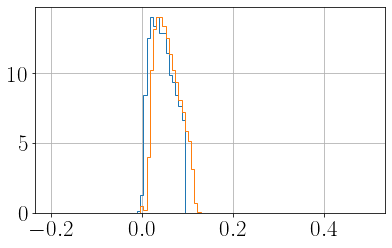

0.5 1.0
1


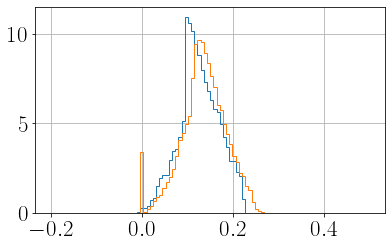

1.0 1.5
2


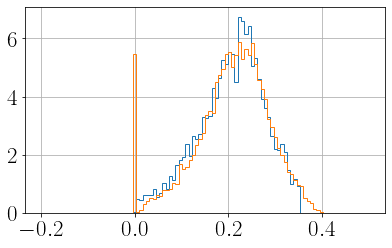

1.5 2.0
3


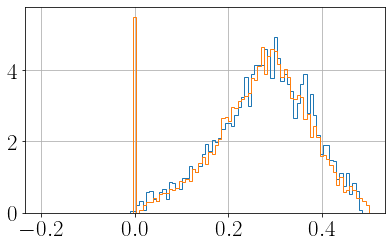

2.0 2.5
4


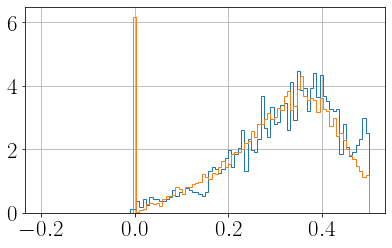

2.5 3.0
5


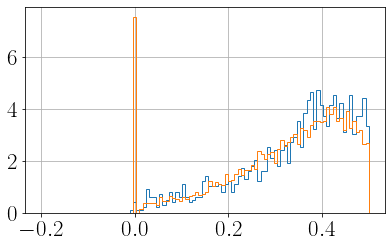

3.0 3.5
6


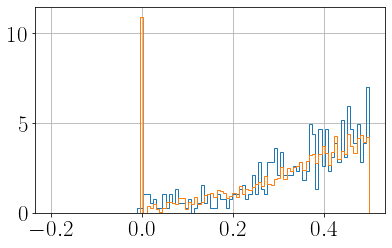

In [888]:
j = 0.5
ind = 0
det = [-0.02, -0.02, -0.02, -0.02, -0.02, -0.02, -0.02, -0.02]
for i in np.linspace(0, 3, 7):
    print(i, i+j)
    exp = pi0ExpInbCD.loc[(pi0ExpInbCD.Gp2>i) & (pi0ExpInbCD.Gp2<i+j)]
    print(ind)
    (exp.Gedep12+corr).hist(bins = np.linspace(-0.2, 0.5, 101), density = True, histtype = 'step')
    pi0SimInbCD.loc[(pi0SimInbCD.Gp2>i) & (pi0SimInbCD.Gp2<i+j)].Gedep12.hist(bins = np.linspace(-0.2, 0.5, 101), density = True, histtype = 'step')
    plt.show()
    ind += 1

3.0 3.5


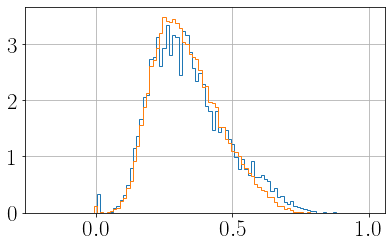

3.5 4.0


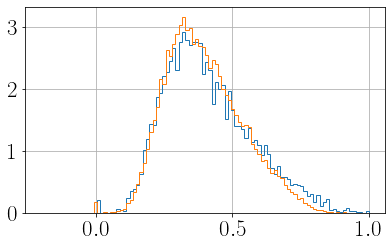

4.0 4.5


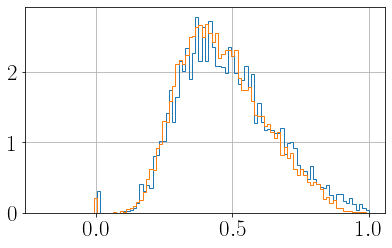

4.5 5.0


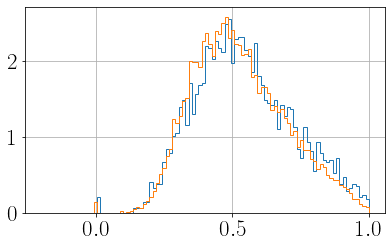

5.0 5.5


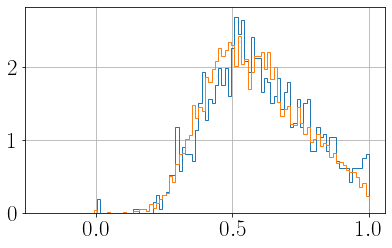

In [903]:
j = 0.5
ind = 0
det = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
for i in np.linspace(3, 5, (5-3)*2+1):
    print(i, i+j)
    exp = pi0ExpInbCD.loc[(pi0ExpInbCD.Gp>i) & (pi0ExpInbCD.Gp<i+j)]
    corr = 0.01+0.07*exp.Gedep2+0.15*exp.Gedep2**2
    (exp.Gedep2+corr).hist(bins = np.linspace(-0.2, 1, 101), density = True, histtype = 'step')
    pi0SimInbCD.loc[(pi0SimInbCD.Gp>i) & (pi0SimInbCD.Gp<i+j)].Gedep2.hist(bins = np.linspace(-0.2, 1, 101), density = True, histtype = 'step')
    plt.show()
    ind += 1

3.0 3.5


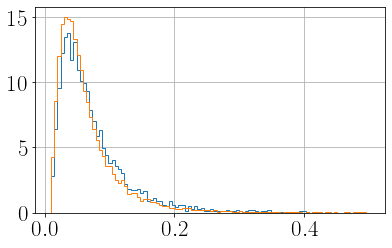

3.5 4.0


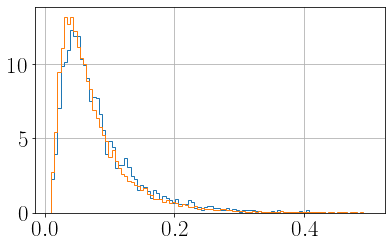

4.0 4.5


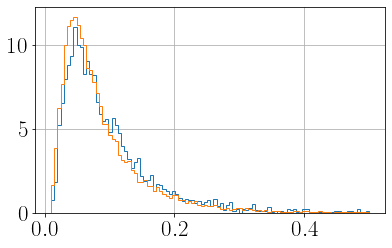

4.5 5.0


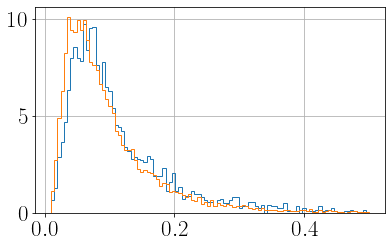

5.0 5.5


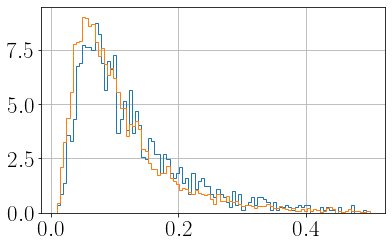

In [849]:
j = 0.5
for i in np.linspace(3, 5, (5-3)*2+1):
    print(i, i+j)
    pi0ExpInbCD.loc[(pi0ExpInbCD.Gp>i) & (pi0ExpInbCD.Gp<i+j)].Gedep3.hist(bins = np.linspace(0.01, 0.5, 101), density = True, histtype = 'step')
    pi0SimInbCD.loc[(pi0SimInbCD.Gp>i) & (pi0SimInbCD.Gp<i+j)].Gedep3.hist(bins = np.linspace(0.01, 0.5, 101), density = True, histtype = 'step')
    plt.show()

5.0 5.5


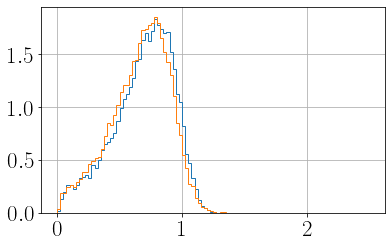

5.5 6.0


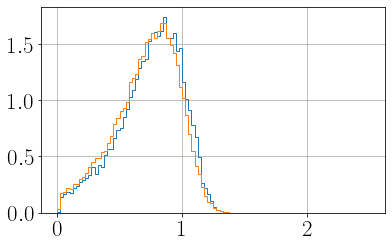

6.0 6.5


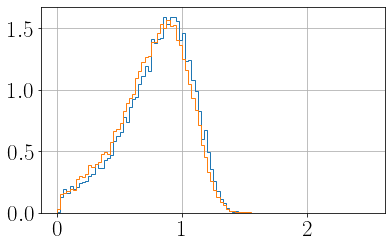

6.5 7.0


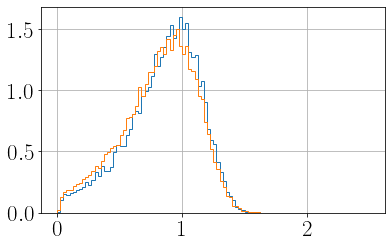

7.0 7.5


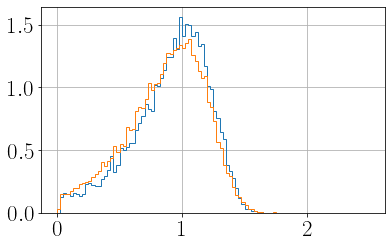

7.5 8.0


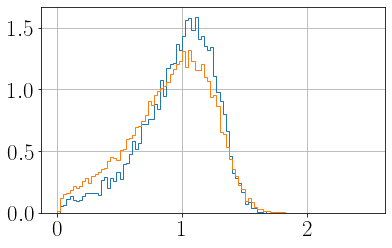

8.0 8.5


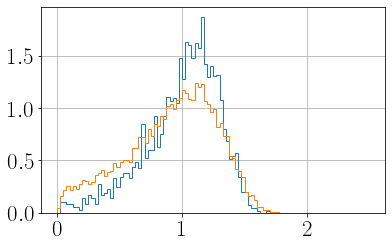

8.5 9.0


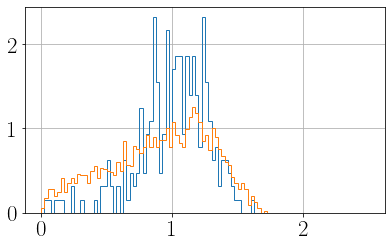

In [895]:
j = 0.5
for i in np.linspace(5, 8.5, int(3.5*2)+1):
    print(i, i+j)
    exp = epgExpInbCD.loc[(epgExpInbCD.Gp>i) & (epgExpInbCD.Gp<i+j)]
    (exp.Gedep1-0.03/(exp.Gedep1+0.5/exp.Gedep1)).hist(bins = np.linspace(0, 2.5, 101), density = True, histtype = 'step')
    dvcsSimInbCD.loc[(dvcsSimInbCD.Gp>i) & (dvcsSimInbCD.Gp<i+j)].Gedep1.hist(bins = np.linspace(0, 2.5, 101), density = True, histtype = 'step')
    plt.show()

5.0 5.5


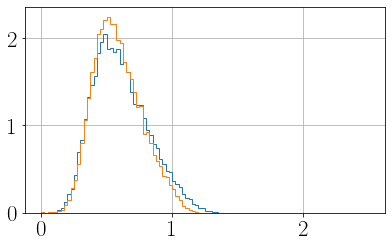

5.5 6.0


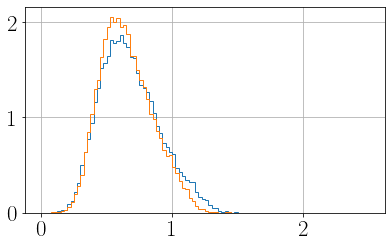

6.0 6.5


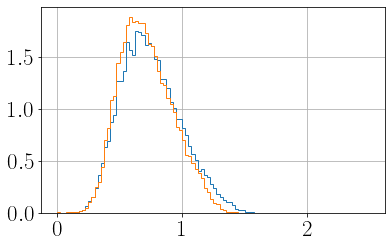

6.5 7.0


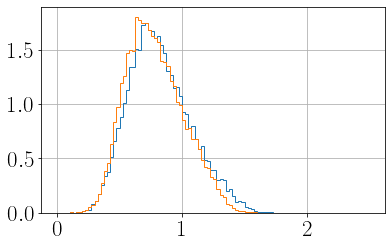

7.0 7.5


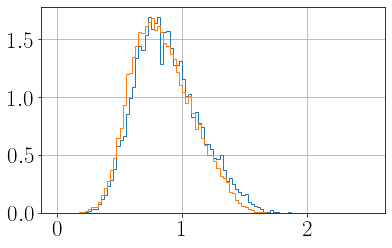

7.5 8.0


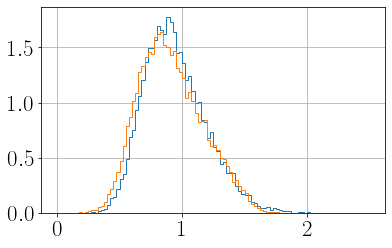

8.0 8.5


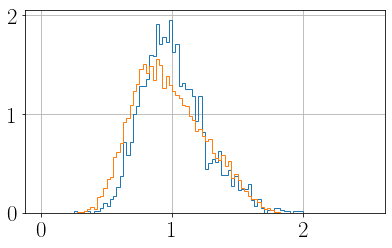

8.5 9.0


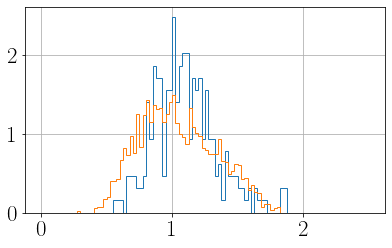

In [897]:
j = 0.5
for i in np.linspace(5, 8.5, int(3.5*2)+1):
    print(i, i+j)
    exp = epgExpInbCD.loc[(epgExpInbCD.Gp>i) & (epgExpInbCD.Gp<i+j)]
    (exp.Gedep2+0.01+0.07*exp.Gedep2+0.15*exp.Gedep2**2).hist(bins = np.linspace(0, 2.5, 101), density = True, histtype = 'step')
    dvcsSimInbCD.loc[(dvcsSimInbCD.Gp>i) & (dvcsSimInbCD.Gp<i+j)].Gedep2.hist(bins = np.linspace(0, 2.5, 101), density = True, histtype = 'step')
    plt.show()

5.0 5.5


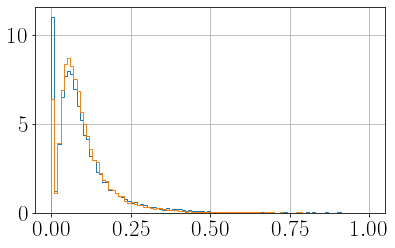

5.5 6.0


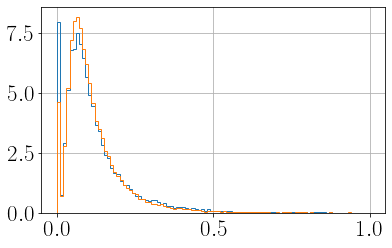

6.0 6.5


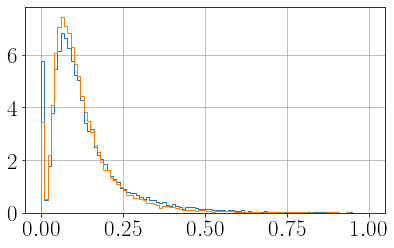

6.5 7.0


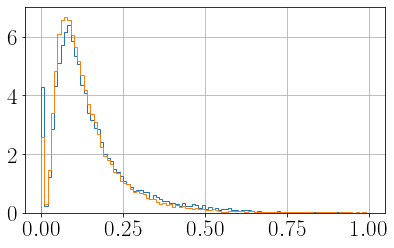

7.0 7.5


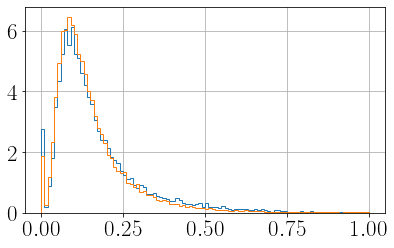

7.5 8.0


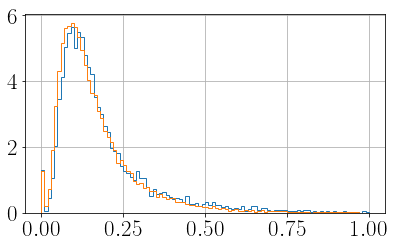

8.0 8.5


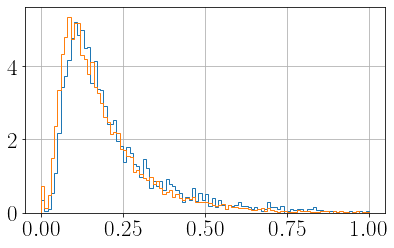

8.5 9.0


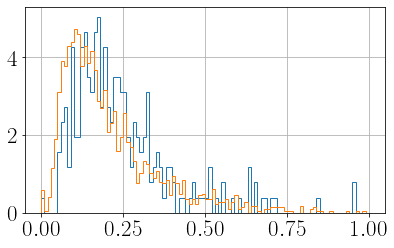

In [902]:
j = 0.5
for i in np.linspace(5, 8.5, int(3.5*2)+1):
    print(i, i+j)
    exp = epgExpInbCD.loc[(epgExpInbCD.Gp>i) & (epgExpInbCD.Gp<i+j)]
    (exp.Gedep3-0.07/(exp.Gedep3+0.5/exp.Gedep3)).hist(bins = np.linspace(0, 1, 101), density = True, histtype = 'step')
    dvcsSimInbCD.loc[(dvcsSimInbCD.Gp>i) & (dvcsSimInbCD.Gp<i+j)].Gedep3.hist(bins = np.linspace(0, 1, 101), density = True, histtype = 'step')
    plt.show()

In [8]:
contCD = len(pi0ExpInbCD)*len(bkgSimInbCD)/len(pi0SimInbCD)/len(epgExpInbCD)

In [823]:
print(contCD)

0.15819901911233836


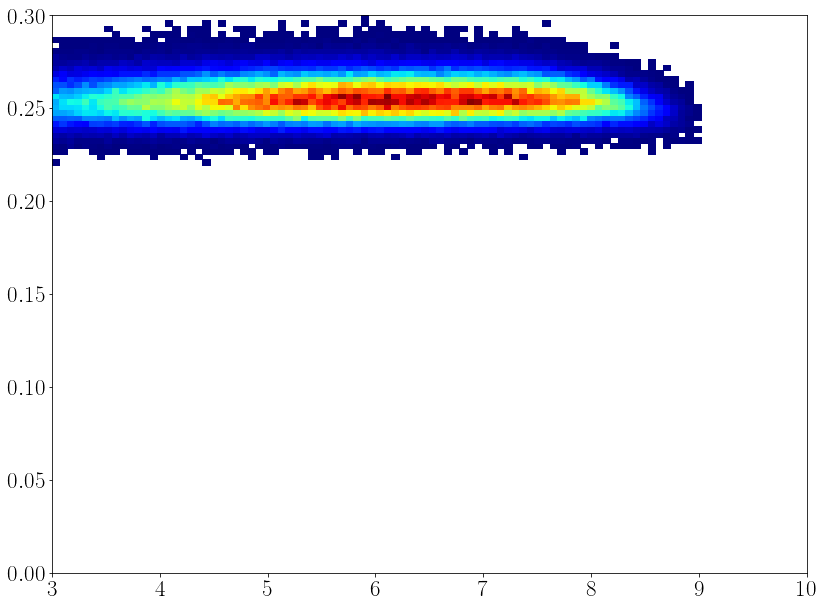

In [1024]:
plt.hist2d(dvcsSimInbCD.Gp, (dvcsSimInbCD.Gedep)/dvcsSimInbCD.Gp, bins = [np.linspace(3, 10, 101), np.linspace(0, 0.3, 101)], cmap = cmap, cmin =1)
plt.show()

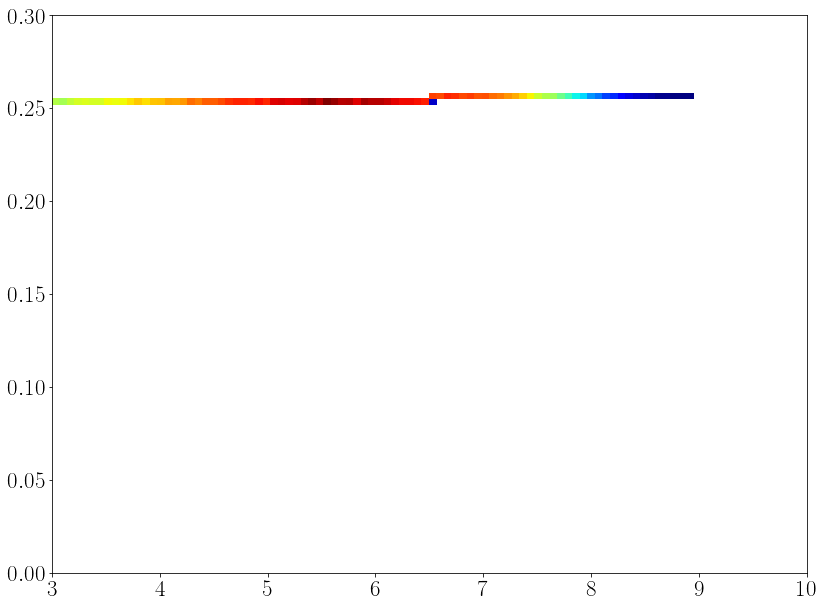

In [1025]:
plt.hist2d(epgExpInbCD.Gp, (epgExpInbCD.Gedep)/epgExpInbCD.Gp, bins = [np.linspace(3, 10, 101), np.linspace(0, 0.3, 101)], cmap = cmap, cmin =1)
plt.show()

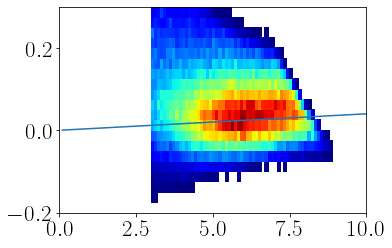

In [392]:
plt.hist2d(epgExpInbCD.Gp, (epgExpInbCD.newGp - epgExpInbCD.Gp)/epgExpInbCD.Gp, bins = [np.linspace(0, 10, 101), np.linspace(-0.2, 0.3, 21)], cmap = cmap, cmin =1)
y = np.linspace(0.1, 10, 101)
plt.plot(y, 0.004*y)
plt.show()

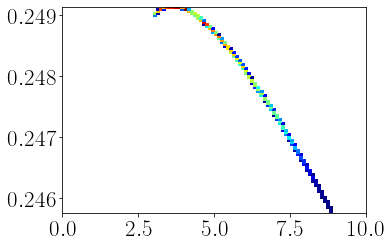

In [399]:
plt.hist2d(epgExpInbCD.Gp, (epgExpInbCD.Gedep)/(epgExpInbCD.Gp+0.0045*epgExpInbCD.Gp**2), bins = [np.linspace(0, 10, 101), 101], cmap = cmap, cmin =1)
y = np.linspace(0.1, 10, 101)
plt.plot(y, 0.004*y)
plt.show()

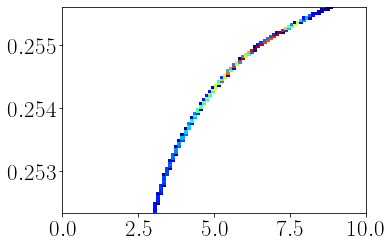

In [398]:
plt.hist2d(epgExpInbCD.Gp, (epgExpInbCD.Gedep)/(epgExpInbCD.Gp), bins = [np.linspace(0, 10, 101), 101], cmap = cmap, cmin =1)
y = np.linspace(0.1, 10, 101)
plt.plot(y, 0.004*y)
plt.show()

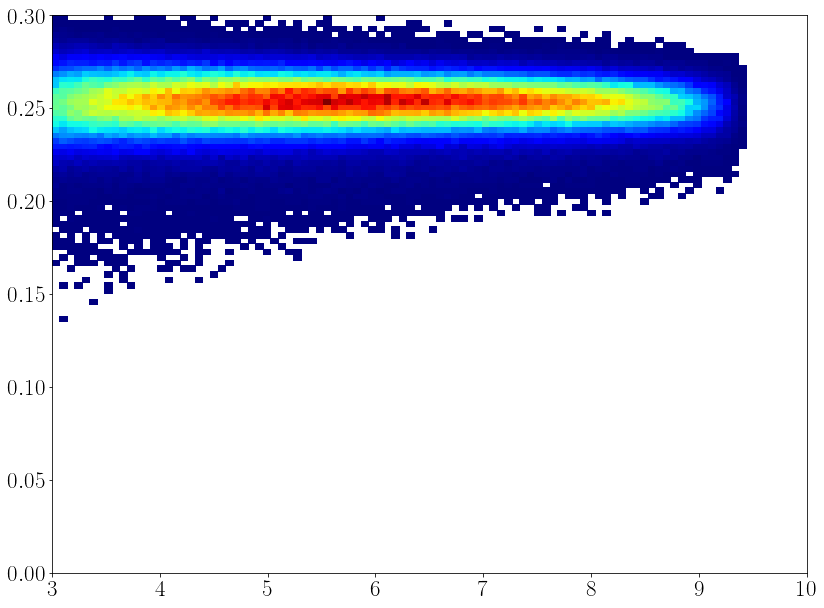

In [1008]:
plt.hist2d(df_3987_corr.loc[df_3987_corr.Gsector<7].GenGp, (df_3987_corr.loc[df_3987_corr.Gsector<7].Gedep)/df_3987_corr.loc[df_3987_corr.Gsector<7].GenGp, bins = [np.linspace(3, 10, 101), np.linspace(0, 0.3, 101)], cmap = cmap, cmin =1)
plt.show()

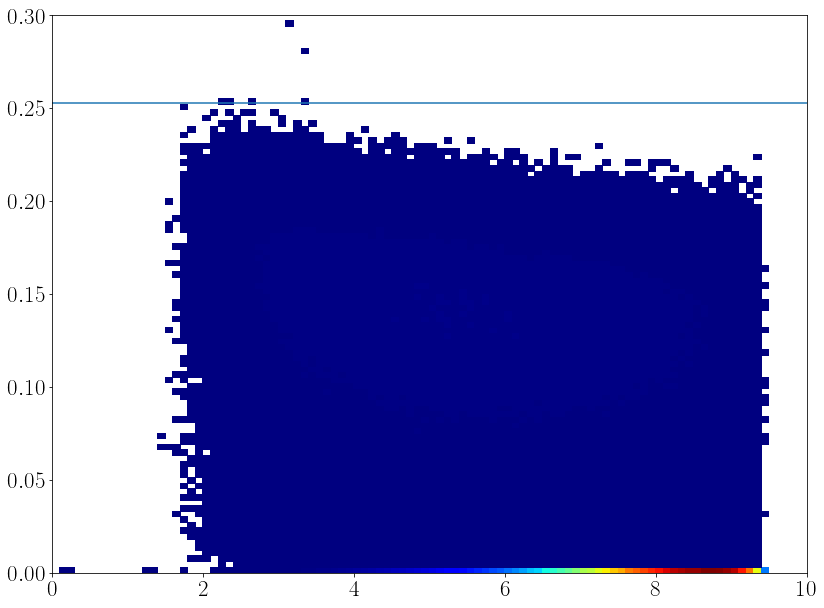

In [966]:
plt.hist2d(df_3987_corr.GenGp, (df_3987_corr.Gedep1)/df_3987_corr.GenGp, bins = [np.linspace(0, 10, 101), np.linspace(0, 0.3, 101)], cmap = cmap, cmin =1)
plt.axhline(0.2525)
plt.show()

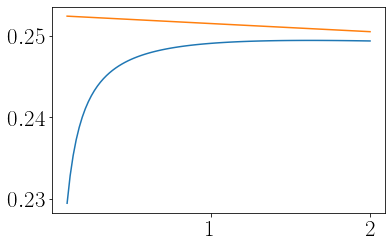

In [536]:
# plt.hist2d(epgExpInbCD.Gedep, (epgExpInbCD.Gedep)/epgExpInbCD.newGp, bins = [np.linspace(0, 2, 101), 31], cmap = cmap, cmin =1)
# plt.axhline(0.2525)
y=np.linspace(0.1, 2, 101)
plt.plot(y, 0.2525*y/(0.01+y+0.0038*y**2))
plt.plot(y, 0.2525*y/(y+0.004*y**2))
plt.show()

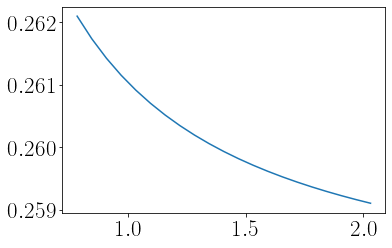

In [66]:
# plt.hist2d(epgExpInbCD.Gedep, (epgExpInbCD.Gedep)/epgExpInbCD.Gp, bins = [np.linspace(0, 2, 101), 31], cmap = cmap, cmin =1)
# plt.axhline(0.2525)
x = np.linspace(0.75+0.5*(2-0.75)/(21-1),2+0.5*(2-0.75)/(21-1),21)
plt.plot(x, 0.25*(1.029+0.015/x+0.00012/x**2))
plt.show()

In [151]:
avg = []
sem = []
for i in np.linspace(0.75,2,21):
    df = epgExpInbCD.loc[(epgExpInbCD.Gedep>i)&(epgExpInbCD.Gedep<i+(2-0.75)/(21-1))]
    samp = df.Gedep/df.newGp
    avg.append(samp.mean())
    sem.append(samp.sem())

In [152]:
(8-3)/(21-1)

0.25

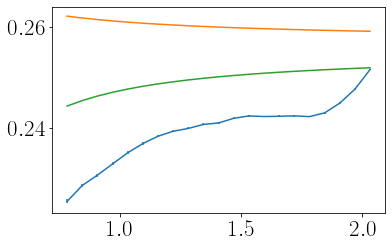

In [159]:
x = np.linspace(0.75+0.5*(2-0.75)/(21-1),2+0.5*(2-0.75)/(21-1),21)
plt.errorbar(x, avg, yerr = sem)
plt.plot(x, 0.25*(1.029+0.015/x+0.00012/x**2))
plt.plot(x, 0.255*(1-0.02/x-0.01/x**2))#0.242*(1+0.05/x-0.08/x**2))

In [1189]:
epgExpInbCD.loc[:, "newGp2"] = epgExpInbCD.Gedep/(0.242*(1+0.05/epgExpInbCD.Gedep-0.08/epgExpInbCD.Gedep**2))

<AxesSubplot:>

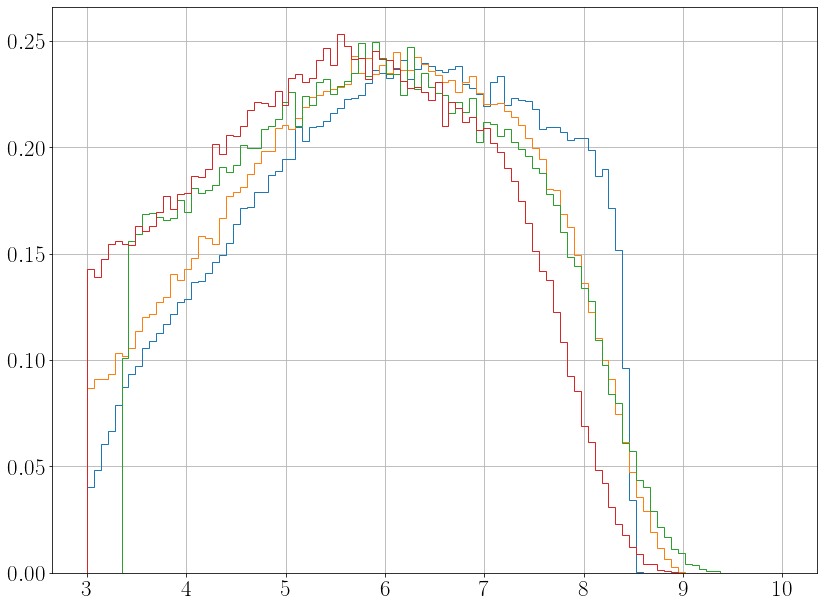

In [1193]:
dvcsSimInbCD.loc[:, "newGp"].hist(bins = np.linspace(3,10,101),density=True, histtype = 'step')
dvcsSimInbCD.loc[:, "Gp"].hist(bins = np.linspace(3,10,101),density=True, histtype = 'step')
epgExpInbCD.loc[:, "newGp2"].hist(bins = np.linspace(3,10,101),density=True, histtype = 'step')
epgExpInbCD.loc[:, "Gp"].hist(bins = np.linspace(3,10,101),density=True, histtype = 'step')

In [937]:
((dvcsSimInbCD.Gedep)/dvcsSimInbCD.GenGp).mean()

0.25212383980768777

Gp
Gedep
Gphi
coneAngle
reconGam
t2
ME_epg
MM2_epg
MM2_eg
coplanarity


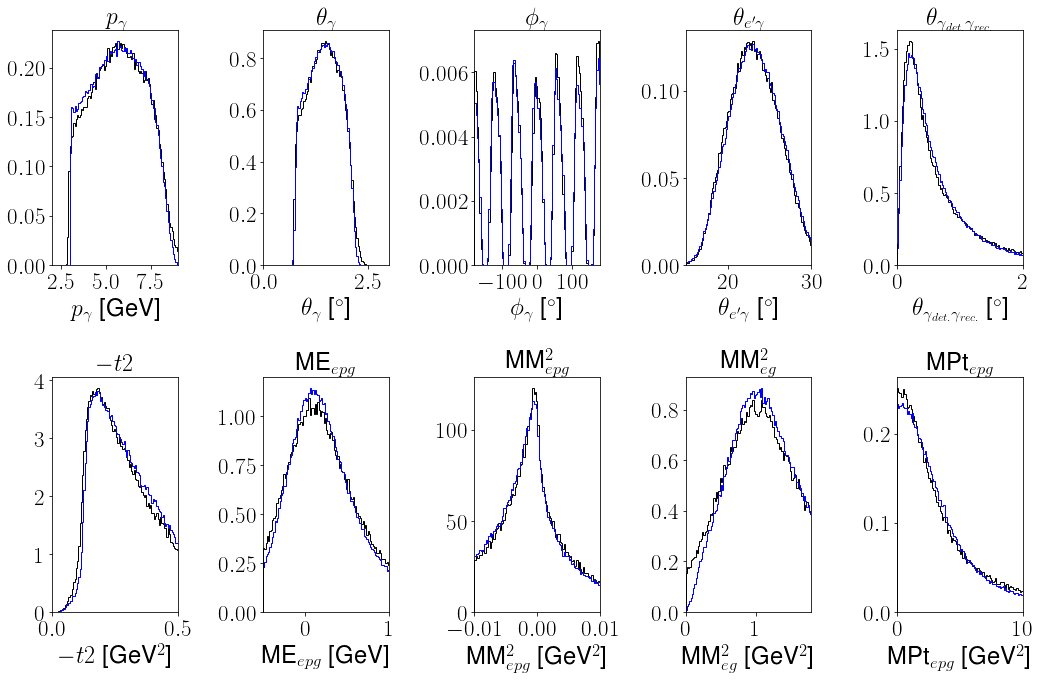

<Figure size 432x288 with 0 Axes>

In [942]:
df1 = dvcsSimInbCD
df2 = bkgSimInbCD
correction = 0.0045*epgExpInbCD.Gp**2 #0.1/(epgExpInbCD.Gedep+0.5/epgExpInbCD.Gedep)#0.015*(epgExpInbCD.Gp+9/epgExpInbCD.Gp)#(0.01*epgExpInbCD.Gedep1+0.04/epgExpInbCD.Gedep1)
#-0.01*epgExpInbCD.Gp+0.1+0.5/epgExpInbCD.Gp
#.3/epgExpInbCD.Gedep1
# 0.004*epgExpInbCD.Gp*epgExpInbCD.Gp
correction1 = -0.05/(epgExpInbCD.Gedep1+0.2/epgExpInbCD.Gedep1)
correction2 = +0.01+0.07*epgExpInbCD.Gedep2+0.15*epgExpInbCD.Gedep2**2#+0.02+0.15*epgExpInbCD.Gedep2**2
correction3 = -0.07/(epgExpInbCD.Gedep3+0.5/epgExpInbCD.Gedep3)


#photon related
varstoplot = ["Gp", "Gedep", "Gphi", "coneAngle",  "reconGam", "t2", "ME_epg", "MM2_epg", "MM2_eg", "coplanarity"]
title = [r"$p_{\gamma}$", r"$\theta_{\gamma}$", r"$\phi_{\gamma}$", r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$-t2$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, GeV2, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [2, 0, -180, 15, 0, 0, -0.5, -0.01, 0, 0]
binends = [9, 3, 180, 30, 2, .5, 1, 0.01, 1.8, 10]
fig, axs = plt.subplots(2, 5, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,5):
        ind = 5*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(df2[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(df1[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0 + (len_epgExpInbCDFT/len_dvcsSimInbCDFT-len_bkgSimInbCDFT/len_pi0SimInbCDFT*len_pi0ExpInbCDFT/len_dvcsSimInbCDFT)*simDist_dvcs
        simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
#         expDist, bins = np.histogram(correctDVCS(epgExpInbCDFT, 0.25)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCDFT-cont_inb_CDFT/len_dvcsSimInbCDFT)*len_epgExpInbCDFT*simDist_dvcs, where='mid',color='r', linewidth=1)
#         axs[yind, xind].hist(correctDVCS3(epgExpInbCD, correction)[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
        axs[yind, xind].hist(correctDVCS3(epgExpInbCD, correction1, correction2, correction3)[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind])#, nphistmean(expDist - len(pi0ExpInbCDFT)/len(pi0SimInbCDFT)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCDFT.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

Gp
Gedep
Gphi
coneAngle
reconGam
t2
ME_epg
MM2_epg
MM2_eg
coplanarity


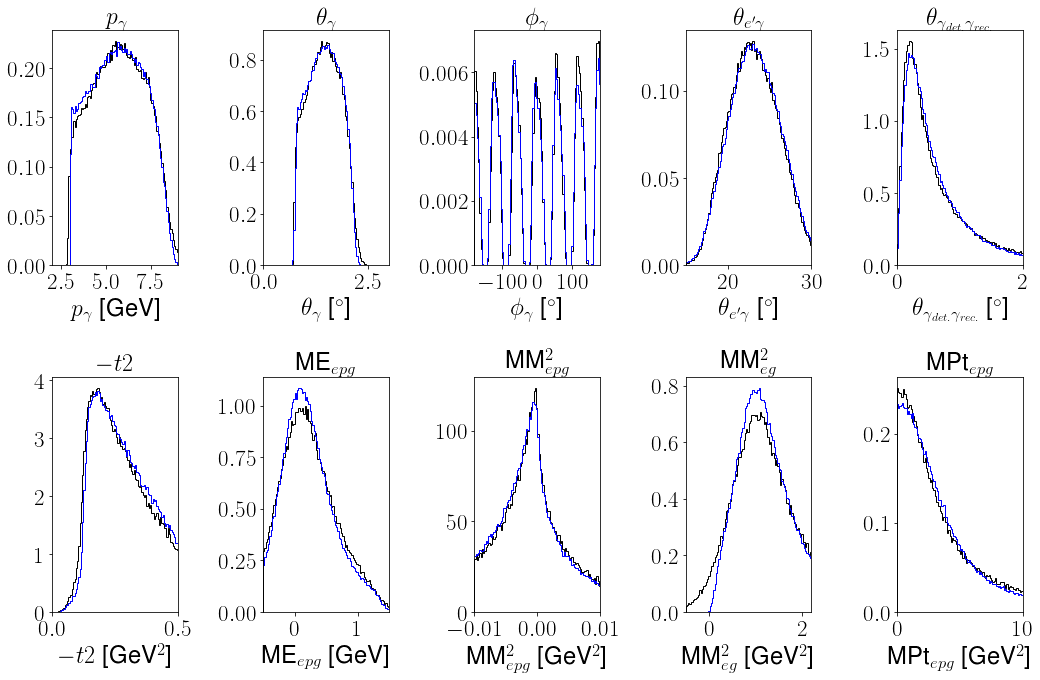

<Figure size 432x288 with 0 Axes>

In [745]:
df1 = dvcsSimInbCD
df2 = bkgSimInbCD
correction = 0#0.004*epgExpInbCD.Gp**2 #0.1/(epgExpInbCD.Gedep+0.5/epgExpInbCD.Gedep)#0.015*(epgExpInbCD.Gp+9/epgExpInbCD.Gp)#(0.01*epgExpInbCD.Gedep1+0.04/epgExpInbCD.Gedep1)
#-0.01*epgExpInbCD.Gp+0.1+0.5/epgExpInbCD.Gp
#.3/epgExpInbCD.Gedep1
# 0.004*epgExpInbCD.Gp*epgExpInbCD.Gp
correction1 = -0.06/(epgExpInbCD.Gedep1+0.3/epgExpInbCD.Gedep1)
correction2 = +0.01+0.07*epgExpInbCD.Gedep2+0.15*epgExpInbCD.Gedep2**2#+0.02+0.15*epgExpInbCD.Gedep2**2
correction3 = -0.07/(epgExpInbCD.Gedep3+0.5/epgExpInbCD.Gedep3)


#photon related
varstoplot = ["Gp", "Gedep", "Gphi", "coneAngle",  "reconGam", "t2", "ME_epg", "MM2_epg", "MM2_eg", "coplanarity"]
title = [r"$p_{\gamma}$", r"$\theta_{\gamma}$", r"$\phi_{\gamma}$", r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$-t2$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, GeV2, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [2, 0, -180, 15, 0, 0, -0.5, -0.01, -0.5, 0]
binends = [9, 3, 180, 30, 2, .5, 1.5, 0.01, 2.2, 10]
fig, axs = plt.subplots(2, 5, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,5):
        ind = 5*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(df2[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(df1[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0 + (len_epgExpInbCDFT/len_dvcsSimInbCDFT-len_bkgSimInbCDFT/len_pi0SimInbCDFT*len_pi0ExpInbCDFT/len_dvcsSimInbCDFT)*simDist_dvcs
        simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
#         expDist, bins = np.histogram(correctDVCS(epgExpInbCDFT, 0.25)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCDFT-cont_inb_CDFT/len_dvcsSimInbCDFT)*len_epgExpInbCDFT*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(correctDVCS3(epgExpInbCD, correction1, correction2, correction3)[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind])#, nphistmean(expDist - len(pi0ExpInbCDFT)/len(pi0SimInbCDFT)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCDFT.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

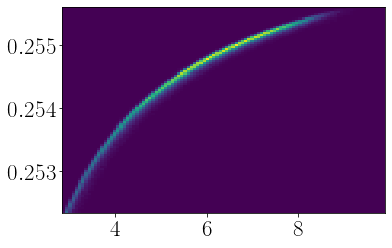

In [738]:
df = correctDVCS3(epgExpInbCD, correction1, correction2, correction3)
plt.hist2d(df.Ge, df.Gedep/df.Ge, bins = 101)
plt.show()

In [18]:
dvcsSimInbCD = reDefineDVCS(dvcsSimInbCD)
bkgSimInbCD = reDefineDVCS(bkgSimInbCD)
epgExpInbCD = reDefineDVCS(epgExpInbCD)

In [ ]:
# correction = 0.0045*epgExpInbCD.Gp**2

varstoplot = ["coneAngle", "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [20, 0, 0, -0.5, -0.01, 0.1,-0.4 , 0]
binends = [60, 2, 10, 1.2, 0.01, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(smearingDVCS3(bkgSimInbCD, 0.035)[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(smearingDVCS3(dvcsSimInbCD, 0.035)[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCD/len_pi0SimInbCD*simDist_dvpi0 + (len_epgExpInbCD/len_dvcsSimInbCD-len_bkgSimInbCD/len_pi0SimInbCD*len_pi0ExpInbCD/len_dvcsSimInbCD)*simDist_dvcs
        simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
        expDist, bins = np.histogram(correctDVCS3(epgExpInbCD, correction1, correction2, correction3)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCD-cont_inb_CD/len_dvcsSimInbCD)*len_epgExpInbCD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(correctDVCS3(epgExpInbCD, correction1, correction2, correction3)[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCD/len_pi0SimInbCD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbCD)/len(pi0SimInbCD)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

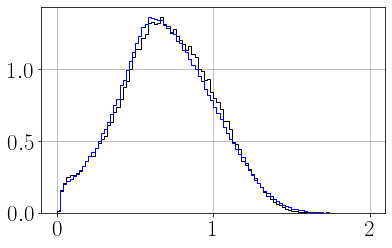

In [938]:
bins = np.linspace(0, 2, 101)
bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])

(epgExpInbCD.Gedep1-0.04/(epgExpInbCD.Gedep1+0.2/epgExpInbCD.Gedep1)).hist(bins = bins, density = True, histtype = 'step', color = 'k')
# (epgExpInbCD.Gp*(epgExpInbCD.Gedep1)/(epgExpInbCD.Gedep1-0.03)).hist(bins = bins, density = True, histtype = 'step', color = 'r')
simDist_dvpi0, bins = np.histogram(bkgSimInbCD.Gedep1, bins, density = True)
simDist_dvcs, bins = np.histogram(dvcsSimInbCD.Gedep1, bins, density = True)
simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
plt.step(bincenters, simDist, where='mid',color='b', linewidth=1)


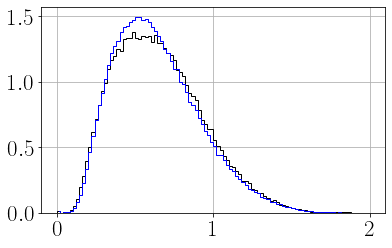

In [743]:
bins = np.linspace(0, 2, 101)
bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])

(epgExpInbCD.Gedep2+0.01+0.07*epgExpInbCD.Gedep2+0.15*epgExpInbCD.Gedep2**2).hist(bins = bins, density = True, histtype = 'step', color = 'k')
# (epgExpInbCD.Gp*(epgExpInbCD.Gedep1)/(epgExpInbCD.Gedep1-0.03)).hist(bins = bins, density = True, histtype = 'step', color = 'r')
simDist_dvpi0, bins = np.histogram(bkgSimInbCD.Gedep2, bins, density = True)
simDist_dvcs, bins = np.histogram(dvcsSimInbCD.Gedep2, bins, density = True)
simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
plt.step(bincenters, simDist, where='mid',color='b', linewidth=1)


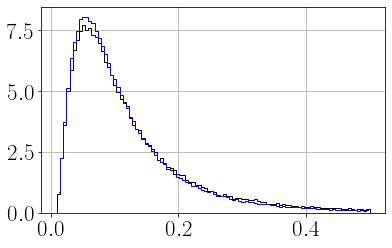

In [628]:
bins = np.linspace(0.01, 0.5, 101)
bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])

(epgExpInbCD.Gedep3-0.06/(epgExpInbCD.Gedep3+0.5/epgExpInbCD.Gedep3)).hist(bins = bins, density = True, histtype = 'step', color = 'k')
# (epgExpInbCD.Gp*(epgExpInbCD.Gedep1)/(epgExpInbCD.Gedep1-0.03)).hist(bins = bins, density = True, histtype = 'step', color = 'r')
simDist_dvpi0, bins = np.histogram(bkgSimInbCD.Gedep3, bins, density = True)
simDist_dvcs, bins = np.histogram(dvcsSimInbCD.Gedep3, bins, density = True)
simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
plt.step(bincenters, simDist, where='mid',color='b', linewidth=1)


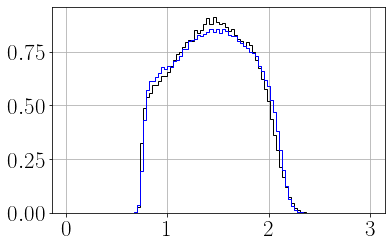

In [742]:
bins = np.linspace(0.01, 3, 101)
bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])

(epgExpInbCD.Gedep-0.06/(epgExpInbCD.Gedep1+0.3/epgExpInbCD.Gedep1)+0.15*epgExpInbCD.Gedep2-0.06/(epgExpInbCD.Gedep3+0.5/epgExpInbCD.Gedep3)).hist(bins = bins, density = True, histtype = 'step', color = 'k')
# (epgExpInbCD.Gp*(epgExpInbCD.Gedep1)/(epgExpInbCD.Gedep1-0.03)).hist(bins = bins, density = True, histtype = 'step', color = 'r')
simDist_dvpi0, bins = np.histogram(bkgSimInbCD.Gedep, bins, density = True)
simDist_dvcs, bins = np.histogram(dvcsSimInbCD.Gedep, bins, density = True)
simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
plt.step(bincenters, simDist, where='mid',color='b', linewidth=1)


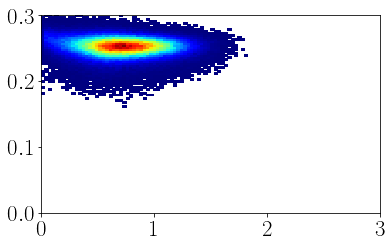

In [70]:
plt.hist2d(dvcsSimInbCD.Gedep1, (dvcsSimInbCD.Gedep)/dvcsSimInbCD.GenGp, bins = [np.linspace(0, 3, 101), np.linspace(0, 0.3, 101)], cmap = cmap, cmin =1)
plt.show()

In [206]:
def smearingDVCS4(df_epg, sigma = 0, sigma2 = 0, sigma3 = 0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    df_epg.loc[df_epg.Psector<7, 'Pp'] = np.random.normal(1, sigma, len(df_epg.loc[df_epg.Psector<7]))*df_epg.loc[df_epg.Psector<7, 'Pp']
    df_epg.loc[df_epg.Psector<7, 'Pe'] = np.sqrt(df_epg.loc[df_epg.Psector<7, 'Pp']**2+M**2)
    df_epg.loc[df_epg.Psector<7, 'Ptheta'] = np.random.normal(0, sigma2, len(df_epg.loc[df_epg.Psector<7]))+df_epg.loc[df_epg.Psector<7, 'Ptheta']
    df_epg.loc[df_epg.Psector>7, 'Pphi'] = np.random.normal(0, sigma3, len(df_epg.loc[df_epg.Psector<7]))+df_epg.loc[df_epg.Psector<7, 'Pphi']
    df_epg.loc[:, "Ppx"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.cos(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppy"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.sin(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppz"] = df_epg.loc[:, "Pp"]*np.cos(np.radians(df_epg.loc[:, "Ptheta"]))
    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]

#     df_epg.loc[:, 'Gp'] = np.random.normal(1, sigma, len(df_epg))*df_epg.loc[:, 'Gp']
#     df_epg.loc[:, 'Ge'] = df_epg.loc[:, 'Gp']
# #     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
# #     df_epg.loc[:, 'Gphi'] = getPhi(gam)
#     df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]
    
    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


In [207]:
def correctDVCS4(df_epg, correction=0, correction2 =0, correction3=0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    df_epg.loc[df_epg.Psector<7, 'Pp'] = df_epg.loc[df_epg.Psector<7, 'Pp'] + correction
    df_epg.loc[df_epg.Psector<7, 'Pe'] = np.sqrt(df_epg.loc[df_epg.Psector<7, 'Pp']**2+M**2)
    df_epg.loc[df_epg.Psector<7, 'Ptheta'] = df_epg.loc[df_epg.Psector<7, 'Ptheta'] + correction2
    df_epg.loc[df_epg.Psector<7, 'Pphi'] = df_epg.loc[df_epg.Psector<7, 'Pphi'] + correction3
    df_epg.loc[:, "Ppx"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.cos(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppy"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.sin(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppz"] = df_epg.loc[:, "Pp"]*np.cos(np.radians(df_epg.loc[:, "Ptheta"]))
    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
    
#     df_epg.loc[df_epg.Gsector>7, 'Gp'] = df_epg.loc[df_epg.Gsector>7, 'Gp'] + 0.25
#     df_epg.loc[df_epg.Gsector>7, 'Ge'] = df_epg.loc[df_epg.Gsector>7, 'Ge'] + 0.25
# #     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
# #     df_epg.loc[:, 'Gphi'] = getPhi(gam)
#     df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]

    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


In [272]:
dvcsSimInbFD.coneAngle

23         29.982351
57         32.535165
99         33.997378
132        30.514642
173        29.731113
             ...    
2107522    35.401243
2107612    31.350221
2107619    29.651813
2107647    33.811769
2107704    33.945626
Name: coneAngle, Length: 45208, dtype: float64

Gp
Gtheta
Gphi
coneAngle
reconGam
t2
ME_epg
MM2_epg
MM2_eg
MPt


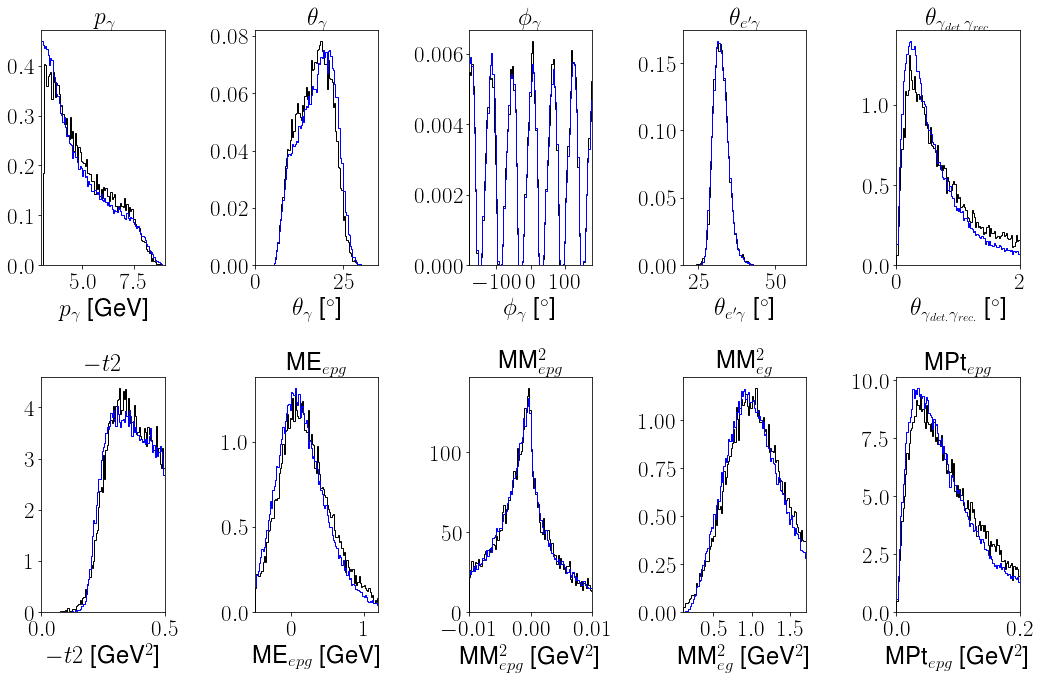

<Figure size 432x288 with 0 Axes>

In [277]:
df1 = smearingDVCS4(dvcsSimInbFD, 0.06, 0, 0)
df2 = smearingDVCS4(bkgSimInbFD, 0.06, 0, 0)
correction = 0.015*(epgExpInbFD.Gp+9/epgExpInbFD.Gp)

#photon related
varstoplot = ["Gp", "Gtheta", "Gphi", "coneAngle",  "reconGam", "t2", "ME_epg", "MM2_epg", "MM2_eg", "MPt"]
title = [r"$p_{\gamma}$", r"$\theta_{\gamma}$", r"$\phi_{\gamma}$", r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$-t2$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, GeV2, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [3, 0, -180, 20, 0, 0, -0.5, -0.01, 0.1, 0]
binends = [9, 35, 180, 60, 2, .5, 1.2, 0.01, 1.7, 0.2]
fig, axs = plt.subplots(2, 5, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,5):
        ind = 5*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(df2[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(df1[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0 + (len_epgExpInbCDFT/len_dvcsSimInbCDFT-len_bkgSimInbCDFT/len_pi0SimInbCDFT*len_pi0ExpInbCDFT/len_dvcsSimInbCDFT)*simDist_dvcs
        simDist = (1-contFD)*simDist_dvcs + contFD*simDist_dvpi0
#         expDist, bins = np.histogram(correctDVCS(epgExpInbCDFT, 0.25)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCDFT-cont_inb_CDFT/len_dvcsSimInbCDFT)*len_epgExpInbCDFT*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(correctDVCS3(epgExpInbFD, correction)[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind])#, nphistmean(expDist - len(pi0ExpInbCDFT)/len(pi0SimInbCDFT)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCDFT.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

## FD proton smearing

In [1074]:
ver = "FD"

parent_MC = "/Volumes/Extreme SSD/nov2021/convPkl_"+ver+"/dvcs/"
parent_MC_bkg1g = "/Volumes/Extreme SSD/nov2021/convPkl_"+ver+"/bkg_1g/"
parent_MC_bkg2g = "/Volumes/Extreme SSD/nov2021/convPkl_"+ver+"/bkg_2g/"
parent_exp = "/Volumes/Extreme SSD/nov2021/convPkl_"+ver+"/exp/"

df_3987_corr = pd.read_pickle(parent_MC + "3987.pkl")
df_4076_1g_corr = pd.read_pickle(parent_MC_bkg1g + "4076.pkl")
df_4076_2g_corr = pd.read_pickle(parent_MC_bkg2g + "4076.pkl")
exp_1g_corr = pd.read_pickle(parent_exp + "dvcs.pkl")
exp_2g_corr = pd.read_pickle(parent_exp + "pi0.pkl")

In [1075]:
epgExpInb = copy(exp_1g_corr)
pi0ExpInb = copy(exp_2g_corr)
dvcsSimInb = copy(df_3987_corr)
bkgSimInb = copy(df_4076_1g_corr)
pi0SimInb = copy(df_4076_2g_corr)

In [1076]:
epgExpInbCD = copy(exp_1g_corr.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector<7)])
pi0ExpInbCD = copy(exp_2g_corr.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>3)&(exp_2g_corr.Pp>0.25)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector>7)&(exp_2g_corr.Ptheta<60))& (exp_2g_corr.Gsector<7)& (exp_2g_corr.Gsector2<7)])
dvcsSimInbCD = copy(dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>3)&(dvcsSimInb.Pp>0.25)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector>7)&(dvcsSimInb.Ptheta<60))& (dvcsSimInb.Gsector<7)])
bkgSimInbCD = copy(bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>3)&(bkgSimInb.Pp>0.25)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector>7)&(bkgSimInb.Ptheta<60))& (bkgSimInb.Gsector<7)])
pi0SimInbCD = copy(pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>3)&(pi0SimInb.Pp>0.25)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector>7)&(pi0SimInb.Ptheta<60))& (pi0SimInb.Gsector<7)])

In [1077]:
epgExpInbFD = copy(exp_1g_corr.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.35)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector<7)&(exp_1g_corr.Ptheta<32))& (exp_1g_corr.Gsector<7)])
pi0ExpInbFD = copy(exp_2g_corr.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>3)&(exp_2g_corr.Pp>0.35)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector<7)&(exp_2g_corr.Ptheta<32))& (exp_2g_corr.Gsector<7)& (exp_2g_corr.Gsector2<7)])
dvcsSimInbFD = copy(dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>3)&(dvcsSimInb.Pp>0.35)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector<7)&(dvcsSimInb.Ptheta<32))& (dvcsSimInb.Gsector<7)])
bkgSimInbFD = copy(bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>3)&(bkgSimInb.Pp>0.35)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector<7)&(bkgSimInb.Ptheta<32))& (bkgSimInb.Gsector<7)])
pi0SimInbFD = copy(pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>3)&(pi0SimInb.Pp>0.35)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector<7)&(pi0SimInb.Ptheta<32))& (pi0SimInb.Gsector<7)])


In [1079]:
epgExpInbCDFT = epgExpInb.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector>7)]
pi0ExpInbCDFT = pi0ExpInb.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>3)&(exp_2g_corr.Pp>0.25)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector>7)&(exp_2g_corr.Ptheta<60))& (exp_2g_corr.Gsector>7)& (exp_2g_corr.Gsector2>7)]
dvcsSimInbCDFT = dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>3)&(dvcsSimInb.Pp>0.25)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector>7)&(dvcsSimInb.Ptheta<60))& (dvcsSimInb.Gsector>7)]
bkgSimInbCDFT = bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>3)&(bkgSimInb.Pp>0.25)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector>7)&(bkgSimInb.Ptheta<60))& (bkgSimInb.Gsector>7)]
pi0SimInbCDFT = pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>3)&(pi0SimInb.Pp>0.25)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector>7)&(pi0SimInb.Ptheta<60))& (pi0SimInb.Gsector>7)]

In [1080]:
contCD = len(pi0ExpInbCD)*len(bkgSimInbCD)/len(pi0SimInbCD)/len(epgExpInbCD)
contFD = len(pi0ExpInbFD)*len(bkgSimInbFD)/len(pi0SimInbFD)/len(epgExpInbFD)

Gp
Gedep
Gphi
coneAngle
reconGam
t2
ME_epg
MM2_epg
MM2_eg
coplanarity


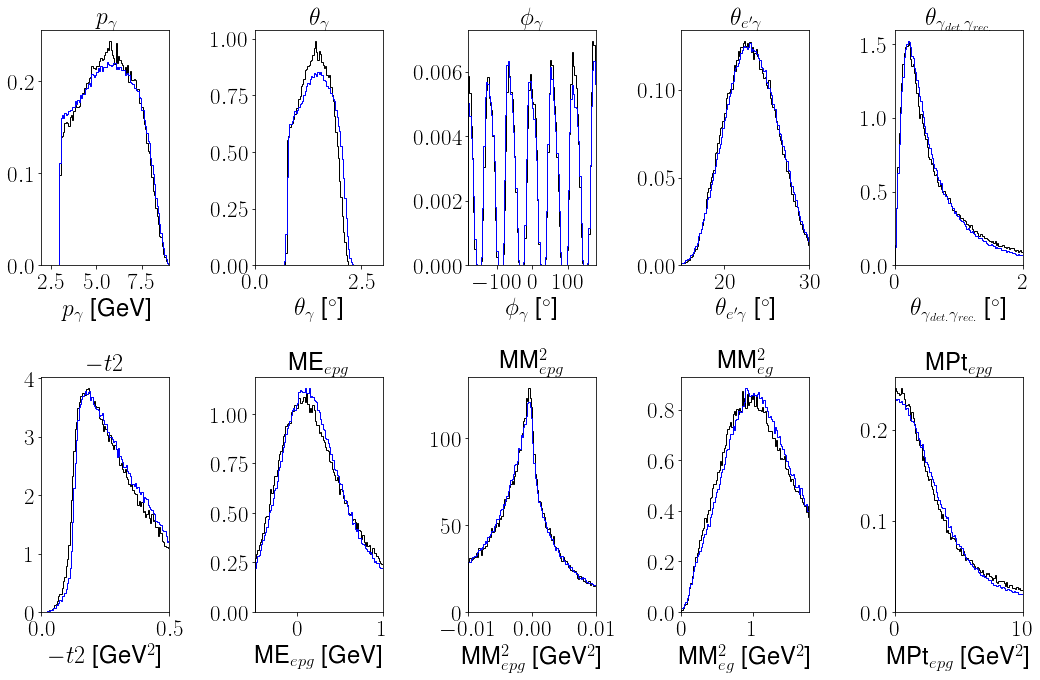

<Figure size 432x288 with 0 Axes>

In [1081]:
df1 = dvcsSimInbCD
df2 = bkgSimInbCD


#photon related
varstoplot = ["Gp", "Gedep", "Gphi", "coneAngle",  "reconGam", "t2", "ME_epg", "MM2_epg", "MM2_eg", "coplanarity"]
title = [r"$p_{\gamma}$", r"$\theta_{\gamma}$", r"$\phi_{\gamma}$", r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$-t2$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, GeV2, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [2, 0, -180, 15, 0, 0, -0.5, -0.01, 0, 0]
binends = [9, 3, 180, 30, 2, .5, 1, 0.01, 1.8, 10]
fig, axs = plt.subplots(2, 5, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,5):
        ind = 5*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(df2[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(df1[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0 + (len_epgExpInbCDFT/len_dvcsSimInbCDFT-len_bkgSimInbCDFT/len_pi0SimInbCDFT*len_pi0ExpInbCDFT/len_dvcsSimInbCDFT)*simDist_dvcs
        simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
#         expDist, bins = np.histogram(correctDVCS(epgExpInbCDFT, 0.25)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCDFT-cont_inb_CDFT/len_dvcsSimInbCDFT)*len_epgExpInbCDFT*simDist_dvcs, where='mid',color='r', linewidth=1)
#         axs[yind, xind].hist(correctDVCS3(epgExpInbCD, correction)[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
        axs[yind, xind].hist(epgExpInbCD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind])#, nphistmean(expDist - len(pi0ExpInbCDFT)/len(pi0SimInbCDFT)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCDFT.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

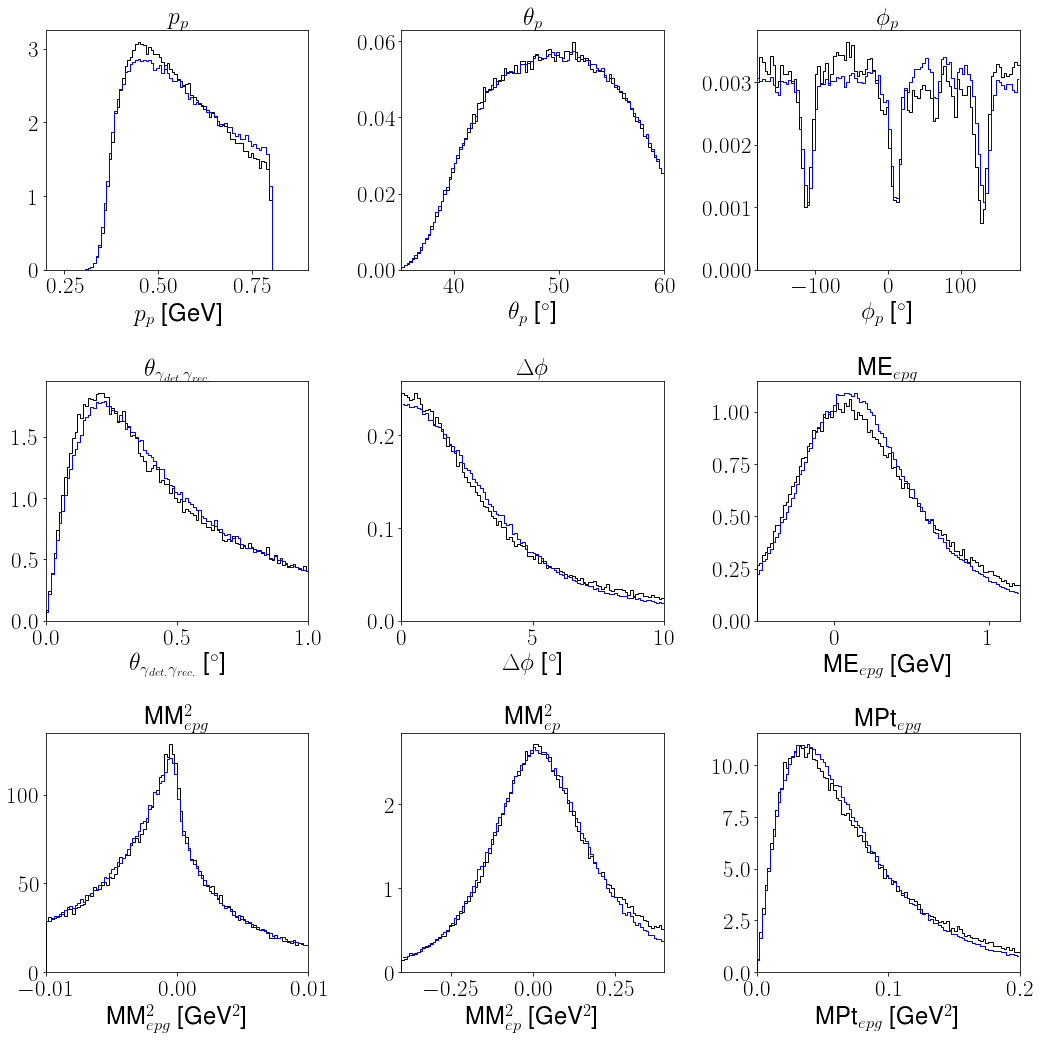

<Figure size 432x288 with 0 Axes>

In [1082]:
#proton related
varstoplot = ["Pp", "Ptheta", "Pphi",  "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_ep", "MPt"]
title = [r"$p_{p}$", r"$\theta_{p}$", r"$\phi_{p}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [0.2, 35, -180, 0, 0, -0.5, -0.01, -0.4, 0]
binends = [0.9, 60, 180, 1, 10, 1.2, 0.01, 0.4, 0.2]
fig, axs = plt.subplots(3, 3, figsize = (15,15))
for yind in range(0, 3):
    for xind in range(0,3):
        ind = 3*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbCD[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbCD[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0 + (len_epgExpInbFD/len_dvcsSimInbFD-len_bkgSimInbFD/len_pi0SimInbFD*len_pi0ExpInbFD/len_dvcsSimInbFD)*simDist_dvcs
        simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbCD[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbFD-cont_inb_FD/len_dvcsSimInbFD)*len_epgExpInbFD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbCD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0, where='mid',color='k', linewidth=1)
#         print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins), simDist.mean())
#         axs[yind, xind].step(bincenters, (1-contCD)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineFD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

coneAngle 32.35011490060845 0.016666666666666666
reconGam 0.6744322272580219 0.5
coplanarity 2.242982645039112 0.19999999999999996
ME_epg 0.1714583134856928 0.5882352941176471
MM2_epg -0.001022193938949493 50.0
MM2_eg 0.9920520972764422 0.625
MM2_ep 0.015822178967278163 1.2499999999999998
MPt 0.05758353930260932 8.333333333333336


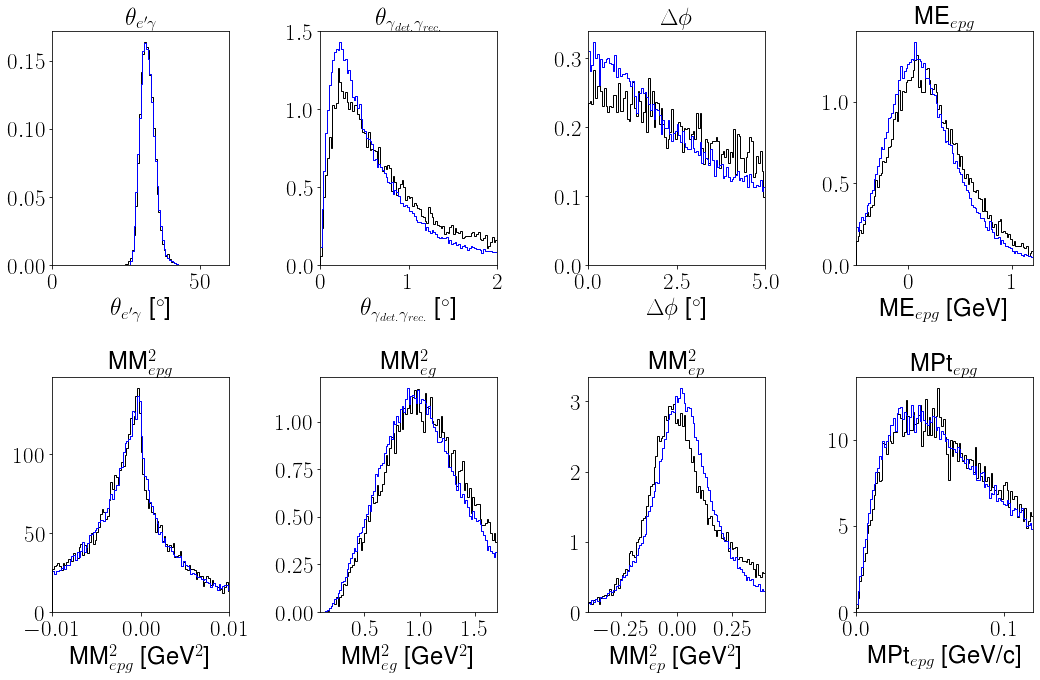

<Figure size 432x288 with 0 Axes>

In [1083]:
correction = 0#0.015*(epgExpInbFD.Gp+9/epgExpInbFD.Gp)

varstoplot = ["coneAngle", "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [0, 0, 0, -0.5, -0.01, 0.1,-0.4 , 0]
binends = [60, 2, 5, 1.2, 0.01, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbFD[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbFD[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0 + (len_epgExpInbFD/len_dvcsSimInbFD-len_bkgSimInbFD/len_pi0SimInbFD*len_pi0ExpInbFD/len_dvcsSimInbFD)*simDist_dvcs
        simDist = (1-contFD)*simDist_dvcs + contFD*simDist_dvpi0
        expDist, bins = np.histogram(correctDVCS4(correctDVCS3(epgExpInbFD, correction), 0, 0, 0)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbFD-cont_inb_FD/len_dvcsSimInbFD)*len_epgExpInbFD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins), simDist.mean())
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineFD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

Gp 5.150733560730624 0.16666666666666669
Gtheta 15.89000634380455 0.028571428571428577
Gphi -1.2480727167226067 0.002777777777777778
coneAngle 32.35142295592885 0.025
reconGam 0.6744322272580219 0.5
t2 0.3532843119538362 2.0000000000000004
ME_epg 0.1714583134856928 0.5882352941176471
MM2_epg -0.001022193938949493 50.0
MM2_eg 0.9920520972764422 0.625
MPt 0.07698976796368429 5.0


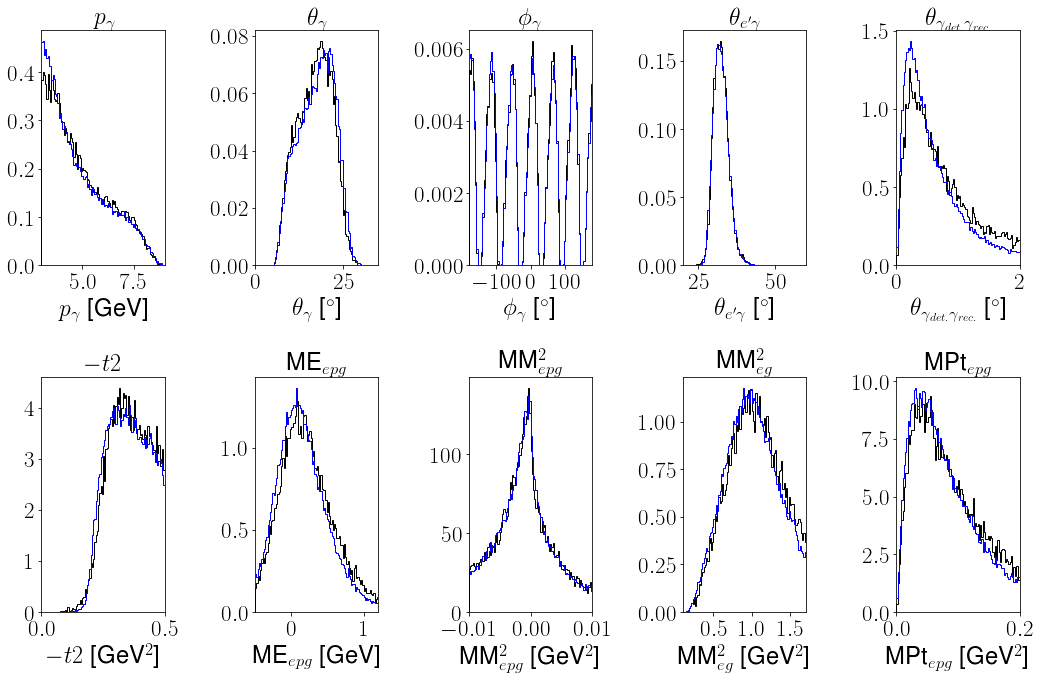

<Figure size 432x288 with 0 Axes>

In [1084]:
correction = 0#0.015*(epgExpInbFD.Gp+9/epgExpInbFD.Gp)

#photon related
varstoplot = ["Gp", "Gtheta", "Gphi", "coneAngle",  "reconGam", "t2", "ME_epg", "MM2_epg", "MM2_eg", "MPt"]
title = [r"$p_{\gamma}$", r"$\theta_{\gamma}$", r"$\phi_{\gamma}$", r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$-t2$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, GeV2, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [3, 0, -180, 20, 0, 0, -0.5, -0.01, 0.1, 0]
binends = [9, 35, 180, 60, 2, .5, 1.2, 0.01, 1.7, 0.2]
fig, axs = plt.subplots(2, 5, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,5):
        ind = 5*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbFD[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbFD[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0 + (len_epgExpInbFD/len_dvcsSimInbFD-len_bkgSimInbFD/len_pi0SimInbFD*len_pi0ExpInbFD/len_dvcsSimInbFD)*simDist_dvcs
        simDist = (1-contFD)*simDist_dvcs + contFD*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbFD[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbFD-cont_inb_FD/len_dvcsSimInbFD)*len_epgExpInbFD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins), simDist.mean())
#         axs[yind, xind].step(bincenters, (1-contFD)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineFD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

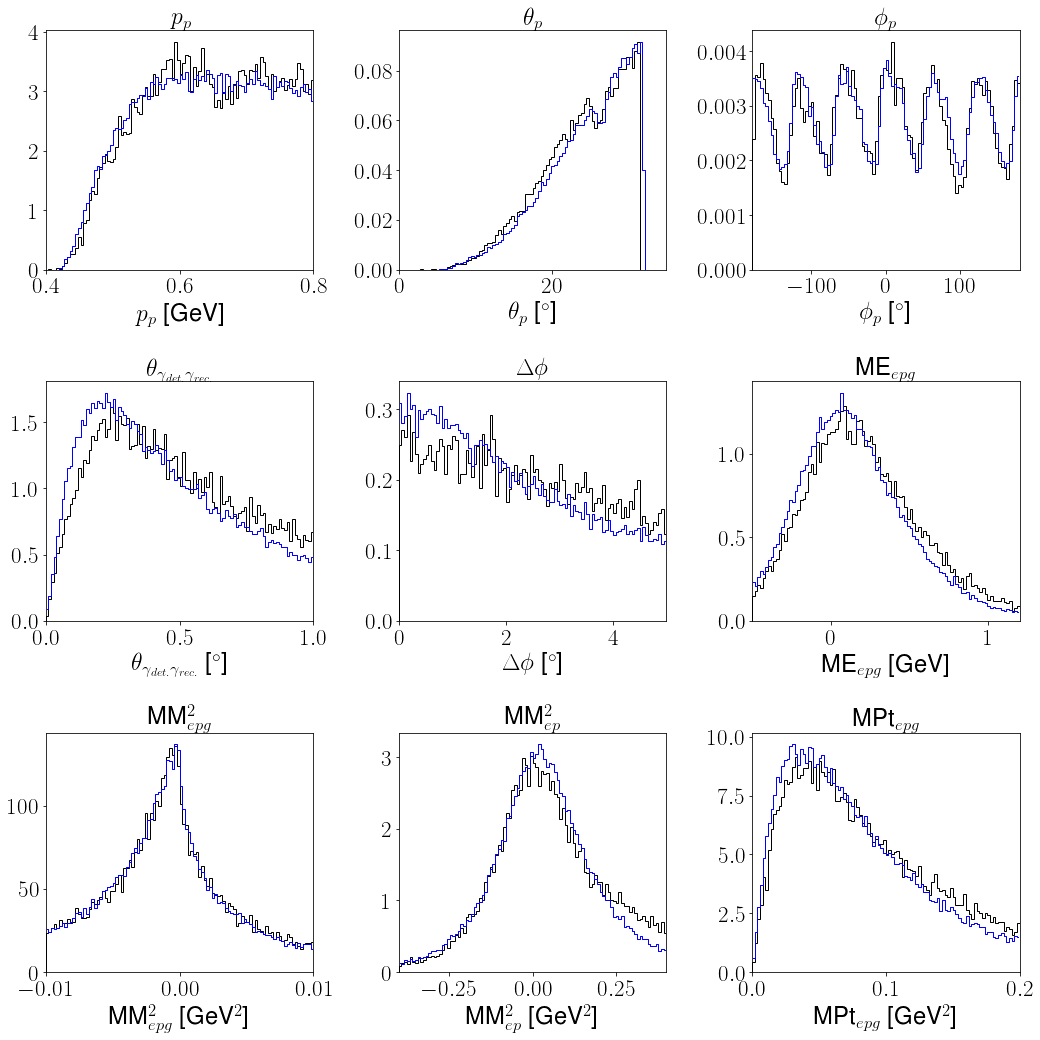

<Figure size 432x288 with 0 Axes>

In [1085]:
#proton related
# df1 = smearingDVCS4(dvcsSimInbFD, np.abs(0.12*(1/(1+np.exp(-(dvcsSimInbFD.Pp-0.42)/0.05))-0.5)), 0, 0)
# df2 = smearingDVCS4(bkgSimInbFD, np.abs(0.12*(1/(1+np.exp(-(bkgSimInbFD.Pp-0.42)/0.05))-0.5)), 0, 0)

df1 = dvcsSimInbFD
df2 = bkgSimInbFD

varstoplot = ["Pp", "Ptheta", "Pphi",  "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_ep", "MPt"]
title = [r"$p_{p}$", r"$\theta_{p}$", r"$\phi_{p}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [0.4, 0, -180, 0, 0, -0.5, -0.01, -0.4, 0]
binends = [0.8, 35, 180, 1, 5, 1.2, 0.01, 0.4, 0.2]
fig, axs = plt.subplots(3, 3, figsize = (15,15))
for yind in range(0, 3):
    for xind in range(0,3):
        ind = 3*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(df2[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(df1[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0 + (len_epgExpInbFD/len_dvcsSimInbFD-len_bkgSimInbFD/len_pi0SimInbFD*len_pi0ExpInbFD/len_dvcsSimInbFD)*simDist_dvcs
        simDist = (1-contFD)*simDist_dvcs + contFD*simDist_dvpi0
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
        axs[yind, xind].hist(correctDVCS4(epgExpInbFD,0, -0.5,0)[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineFD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

In [1044]:
0.16*(1/(1+np.exp(-(1-0.42)/0.1))-0.5)

0.07951705338804667

In [1025]:
0.3*(1/(1+np.exp(-(1-0.35)/0.3))-0.5)

0.11916479252482448

In [1035]:
dvcsSimInbFD.Pp.min()

0.4218003608926781

In [1036]:
bkgSimInbFD.Pp.min()

0.4248487537830805

In [1037]:
epgExpInbFD.Pp.min()

0.35288795513838467

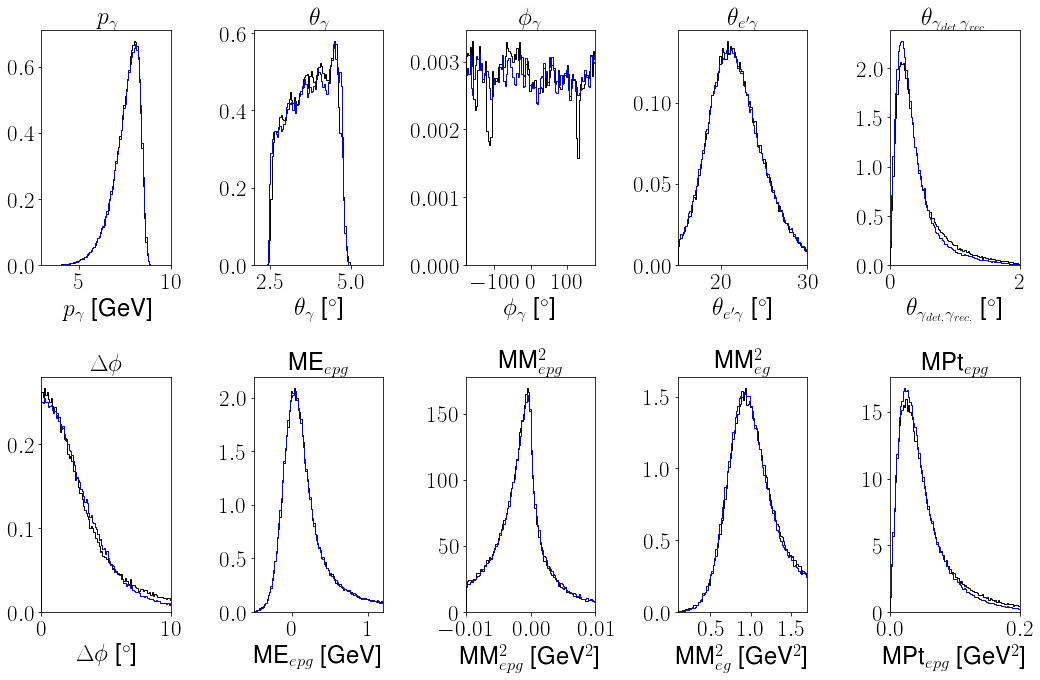

<Figure size 432x288 with 0 Axes>

In [1087]:
#photon related
varstoplot = ["Gp", "Gtheta", "Gphi", "coneAngle",  "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MPt"]
title = [r"$p_{\gamma}$", r"$\theta_{\gamma}$", r"$\phi_{\gamma}$", r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [3, 2, -180, 15, 0, 0, -0.5, -0.01, 0.1, 0]
binends = [10, 6, 180, 30, 2, 10, 1.2, 0.01, 1.7, 0.2]
fig, axs = plt.subplots(2, 5, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,5):
        ind = 5*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
#         simDist_dvpi0, bins = np.histogram(bkgSimInbCDFT[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbCDFT[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0 + (len_epgExpInbCDFT/len_dvcsSimInbCDFT-len_bkgSimInbCDFT/len_pi0SimInbCDFT*len_pi0ExpInbCDFT/len_dvcsSimInbCDFT)*simDist_dvcs
#         simDist = (1-contCDFT)*simDist_dvcs + contCDFT*simDist_dvpi0
        simDist = simDist_dvcs
#         expDist, bins = np.histogram(correctDVCS(epgExpInbCDFT, 0.25)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCDFT-cont_inb_CDFT/len_dvcsSimInbCDFT)*len_epgExpInbCDFT*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0, where='mid',color='k', linewidth=1)
#         print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbCDFT)/len(pi0SimInbCDFT)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCDFT.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

t1
Ptheta
Pphi
reconGam
coplanarity
ME_epg
MM2_epg
MM2_ep
MPt


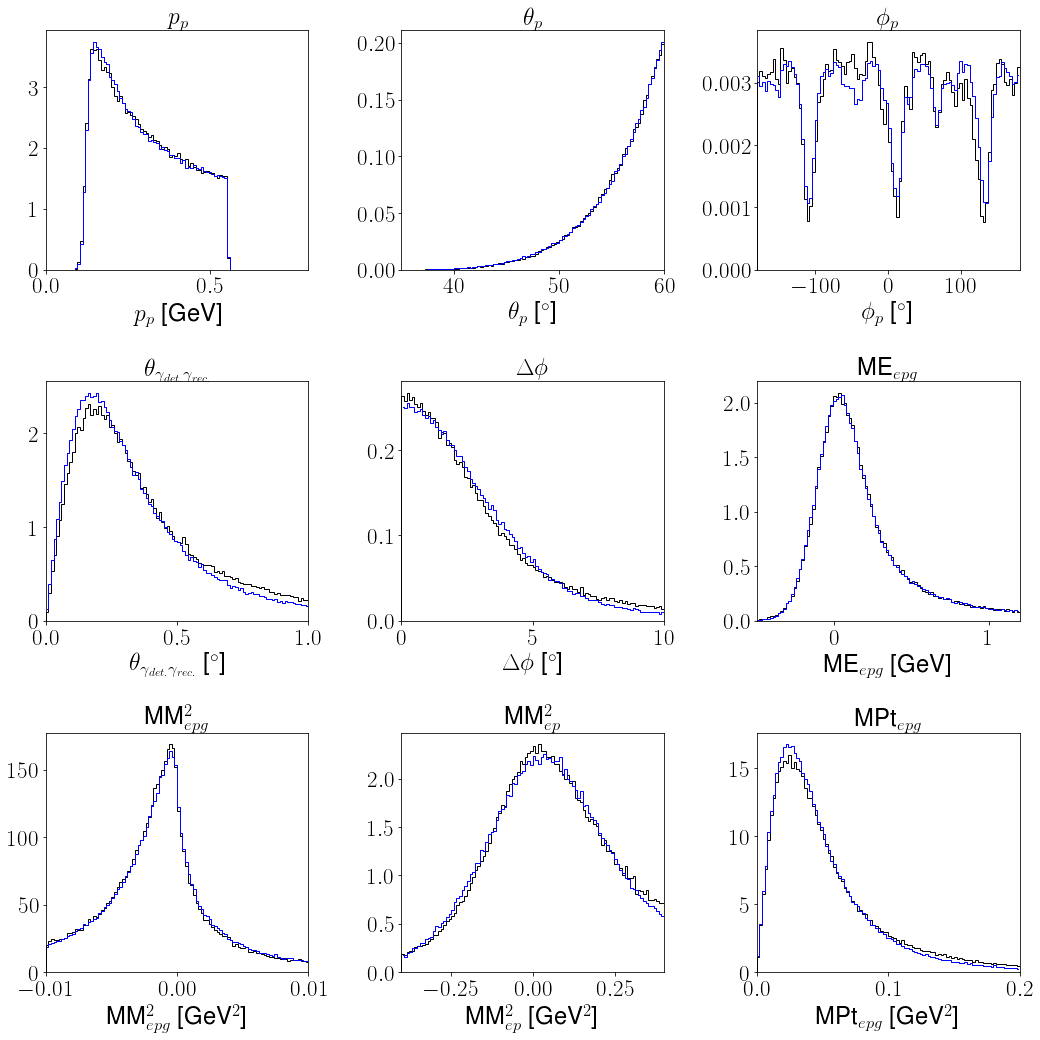

<Figure size 432x288 with 0 Axes>

In [1090]:
#proton related
# df = makeDVCS(smearingDVCS2(dvcsSimInbCDFT, 0.04, 0, 0))
df = dvcsSimInbCDFT

varstoplot = ["t1", "Ptheta", "Pphi",  "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_ep", "MPt"]
title = [r"$p_{p}$", r"$\theta_{p}$", r"$\phi_{p}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, degree, degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [0, 35, -180, 0, 0, -0.5, -0.01, -0.4, 0]
binends = [0.8, 60, 180, 1, 10, 1.2, 0.01, 0.4, 0.2]
fig, axs = plt.subplots(3, 3, figsize = (15,15))
for yind in range(0, 3):
    for xind in range(0,3):
        ind = 3*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
#         simDist_dvpi0, bins = np.histogram(smearingDVCS2(bkgSimInbCDFT, 0.5*bkgSimInbCDFT.Pp**2, 0.7, 2.2)[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(df[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0 + (len_epgExpInbCDFT/len_dvcsSimInbCDFT-len_bkgSimInbCDFT/len_pi0SimInbCDFT*len_pi0ExpInbCDFT/len_dvcsSimInbCDFT)*simDist_dvcs
#         simDist = (1-contCDFT)*simDist_dvcs + contCDFT*simDist_dvpi0
        simDist = simDist_dvcs
#         expDist, bins = np.histogram(correctDVCS(epgExpInbCDFT, 0.25)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCDFT-cont_inb_CDFT/len_dvcsSimInbCDFT)*len_epgExpInbCDFT*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind])#, nphistmean(expDist - len(pi0ExpInbCDFT)/len(pi0SimInbCDFT)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCDFT.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()